In [54]:
import re
from collections import Counter
import pandas as pd
import numpy as np
import ast

from Levenshtein import distance, ratio, seqratio
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# Загрузка данных багфиксов

In [55]:
path_to_data = '/home/kks/zephyr_data/buggy_code/'
source_code_data = pd.read_pickle(path_to_data + 'filtered_traceback_bugfixes.pickle')

Число сниппетов кода с ошибками в датасете:

In [56]:
source_code_data.shape[0]

23580

In [57]:
source_code_data['actual_function_name'] = source_code_data['function_name'].apply(lambda x: x.split('.')[-1])
source_code_data['class_name'] = source_code_data['function_name'].apply(lambda x: x.split('.')[0] if len(x.split('.')) == 2 else np.nan)

# Распределение сниппетов по функциям и методам

In [58]:
source_code_data['class_name'].notna().sum()

15395

Теперь количество функций:

In [59]:
source_code_data['class_name'].isna().sum()

8185

Количество private-методов:

In [60]:
methods_data = source_code_data.loc[source_code_data['class_name'].notna()]
methods_data['actual_function_name'].apply(lambda x: x.startswith('__') and (not x.endswith('__'))).sum()

86

Количество protected-методов:

In [61]:
methods_data['actual_function_name'].apply(lambda x: (len(x) > 1) and (x[0] == '_') and (x[1] != '_')).sum()

2962

Число методов с именем из одного символа.

In [62]:
methods_data['actual_function_name'].apply(lambda x: len(x) == 1).sum()

15

Число декорированных методов:

In [63]:
#methods_data['before_merge'].apply(lambda x: x.startswith('@')).sum()

Число свойств (атрибутов), getters:

In [64]:
#methods_data['before_merge'].apply(lambda x: x.startswith('@property')).sum()

Число сеттеров:

In [65]:
#methods_data['before_merge'].apply(lambda x: x.startswith('@') and x.split()[0].endswith('.setter')).sum()

Число классовых методов:

In [66]:
#methods_data['before_merge'].apply(lambda x: x.startswith('@classmethod')).sum()

Число статических методов:

In [67]:
#methods_data['before_merge'].apply(lambda x: x.startswith('@staticmethod')).sum()

Число специальных методов `__funcname__`:

In [68]:
methods_data['actual_function_name'].apply(lambda x: x.startswith('__') and x.endswith('__')).sum()

2332

Число конструкторов:

In [69]:
methods_data['actual_function_name'].apply(lambda x: x == '__init__').sum()

1693

Какие бывают еще специальные функции в датасете с учетом частоты:

In [70]:
special_methods_data = methods_data.loc[methods_data['actual_function_name'].apply(lambda x:  x.startswith('__') and 
                                                                                               x.endswith('__') and 
                                                                                               x != '__init__'), 
                                        'actual_function_name']
df = special_methods_data.value_counts()

for func_name, func_count in zip(df.index, df):
    print(func_name, func_count)

__call__ 159
__getitem__ 68
__new__ 51
__repr__ 39
__str__ 38
__setitem__ 31
__getattr__ 22
__eq__ 17
__enter__ 15
__iter__ 12
__del__ 12
__exit__ 11
__getstate__ 9
__lt__ 9
__add__ 9
__setstate__ 8
__getattribute__ 7
__len__ 7
__hash__ 6
__sub__ 6
__delitem__ 5
__mul__ 5
__contains__ 4
__rmul__ 4
__floordiv__ 4
__pow__ 4
__truediv__ 3
__get__ 3
__singleton_init__ 3
__radd__ 3
__le__ 3
__deepcopy__ 3
__mars_tensor__ 3
__setattr__ 3
__divmod__ 3
__mod__ 3
__div__ 3
__array_ufunc__ 2
__update__ 2
__gt__ 2
__rsub__ 2
__int__ 2
__rtruediv__ 2
__reduce__ 2
__add_new_params__ 2
__or__ 2
__rdiv__ 1
__rdivmod__ 1
__ge__ 1
__rpow__ 1
__geo_interface__ 1
__ne__ 1
__rfloordiv__ 1
__next__ 1
__neg__ 1
__aiter__ 1
__rmod__ 1
__get_validators__ 1
__aexit__ 1
__bool__ 1
__rmatmul__ 1
__mars_tokenize__ 1
__check__ 1
__dask_scheduler__ 1
__iadd__ 1
__rpc__ 1
__class_getitem__ 1
__delattr__ 1
__array_finalize__ 1
__fspath__ 1
__ray_terminate__ 1
__constructor__ 1


Наиболее часто встречающиеся специальные функции, неконструкторы - это `__getitem__` и `__call__`.

Количество непубличных функций:

In [71]:
functions_data = source_code_data.loc[source_code_data['class_name'].isna()]
functions_data['actual_function_name'].apply(lambda x: (len(x) > 1) and (x.startswith('_'))).sum()

1482

Количество декорированных функций:

In [72]:
#functions_data['before_merge'].apply(lambda x: x.startswith('@')).sum()

Количество специальных функций:

In [73]:
functions_data['actual_function_name'].apply(lambda x: x.startswith('__') and x.endswith('__')).sum()

170

Количество функций `__init__`:

In [74]:
functions_data['actual_function_name'].apply(lambda x: x == '__init__').sum()

60

Таким образом, функции `__init__` и конструкторы очень часто встречаются среди специальных функций.

Количество асинхронных функций и методов:

In [75]:
source_code_data['before_merge'].apply(lambda x: 'async def' in x.split('\n')[0] if len(x.split('\n')) == 1 else
                                       ('async def' in x.split('\n')[0]) or ('async def' in x.split('\n')[1])).sum()

774

# Подсчет процента неправильно размеченных багфиксов

## Число и процент бакфиксов, содержащих правки только в докстрингах или комментариях

Количество таких сниппетов

In [76]:
(source_code_data['after_merge_without_docstrings'] == source_code_data['before_merge_without_docstrings']).sum()

634

Доля таких сниппетов

In [77]:
(source_code_data['after_merge_without_docstrings'] == source_code_data['before_merge_without_docstrings']).sum() / source_code_data.shape[0]

0.0268871925360475

Это является нижней оценкой доли неправильной разметки. При сборе тестового датасета процент рефакторинга был до 15%: было просмотрено порядка нескольких сотен сниппетов.
Ниже оценивается сколько сниппетов меняются не слишком сильно после исправления по длине своей реализации (без докстрингов и комментариев). Их около 1000. Таким образом, если в код (но не в документацию) вносятся достаточно простые правки типа изменения имен переменных или другой рефакторинг, то таких сниппетов не более, чем 

In [78]:
1000/23400

0.042735042735042736

# Общая длина кода в символах

In [79]:
source_code_data['code_length_before'] = source_code_data['before_merge'].apply(lambda x: len(x))
source_code_data['code_length_after'] = source_code_data['after_merge'].apply(lambda x: len(x))

По коду с ошибками:

In [80]:
print(f'Среднее значение длины сниппетов равно {source_code_data["code_length_before"].mean()}.')
print(f'Медиана длины сниппетов равна {source_code_data["code_length_before"].median()}.')
print(f'С.к.о длины сниппетов равно {source_code_data["code_length_before"].std()}.')
print(f'25-й персентиль длины сниппетов равен {source_code_data["code_length_before"].quantile(q=0.25)}.')
print(f'75-й персентиль длины сниппетов равен {source_code_data["code_length_before"].quantile(q=0.75)}.')
print(f'90-й персентиль длины сниппетов равен {source_code_data["code_length_before"].quantile(q=0.90)}.')
print(f'Минимум длины сниппетов равен {source_code_data["code_length_before"].min()}.')
print(f'Максимум длины сниппетов равен {source_code_data["code_length_before"].max()}.')

Среднее значение длины сниппетов равно 1875.9176420695505.
Медиана длины сниппетов равна 934.5.
С.к.о длины сниппетов равно 3766.9099678271173.
25-й персентиль длины сниппетов равен 426.0.
75-й персентиль длины сниппетов равен 2010.0.
90-й персентиль длины сниппетов равен 4081.3000000000065.
Минимум длины сниппетов равен 19.
Максимум длины сниппетов равен 185063.


Теперь отдельно по методам:

In [81]:
methods_data = source_code_data.loc[source_code_data['class_name'].notna()]

In [82]:
print(f'Среднее значение длины сниппетов равно {methods_data["code_length_before"].mean()}.')
print(f'Медиана длины сниппетов равна {methods_data["code_length_before"].median()}.')
print(f'С.к.о длины сниппетов равно {methods_data["code_length_before"].std()}.')
print(f'25-й персентиль длины сниппетов равен {methods_data["code_length_before"].quantile(q=0.25)}.')
print(f'75-й персентиль длины сниппетов равен {methods_data["code_length_before"].quantile(q=0.75)}.')
print(f'90-й персентиль длины сниппетов равен {methods_data["code_length_before"].quantile(q=0.90)}.')
print(f'Минимум длины сниппетов равен {methods_data["code_length_before"].min()}.')
print(f'Максимум длины сниппетов равен {methods_data["code_length_before"].max()}.')

Среднее значение длины сниппетов равно 1548.9849301721338.
Медиана длины сниппетов равна 841.0.
С.к.о длины сниппетов равно 3177.5986454019767.
25-й персентиль длины сниппетов равен 383.0.
75-й персентиль длины сниппетов равен 1753.0.
90-й персентиль длины сниппетов равен 3419.2000000000007.
Минимум длины сниппетов равен 28.
Максимум длины сниппетов равен 185063.


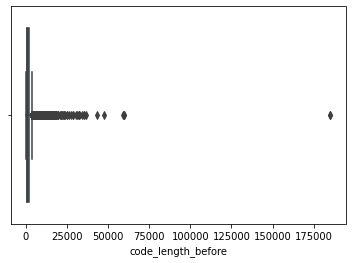

In [83]:
sns.boxplot(x='code_length_before',
            data=methods_data);

Теперь удалим выбросы:

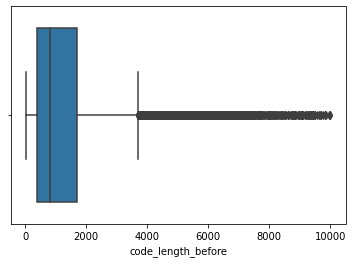

In [84]:
sns.boxplot(x='code_length_before',
            data=methods_data.loc[methods_data['code_length_before'] < 10000]);

Теперь по функциям:

In [85]:
functions_data = source_code_data.loc[source_code_data['class_name'].isna()]

In [86]:
print(f'Среднее значение длины сниппетов равно {functions_data["code_length_before"].mean()}.')
print(f'Медиана длины сниппетов равна {functions_data["code_length_before"].median()}.')
print(f'С.к.о длины сниппетов равно {functions_data["code_length_before"].std()}.')
print(f'25-й персентиль длины сниппетов равен {functions_data["code_length_before"].quantile(q=0.25)}.')
print(f'75-й персентиль длины сниппетов равен {functions_data["code_length_before"].quantile(q=0.75)}.')
print(f'90-й персентиль длины сниппетов равен {functions_data["code_length_before"].quantile(q=0.90)}.')
print(f'Минимум длины сниппетов равен {functions_data["code_length_before"].min()}.')
print(f'Максимум длины сниппетов равен {functions_data["code_length_before"].max()}.')

Среднее значение длины сниппетов равно 2490.838729383018.
Медиана длины сниппетов равна 1145.0.
С.к.о длины сниппетов равно 4616.27623443616.
25-й персентиль длины сниппетов равен 529.0.
75-й персентиль длины сниппетов равен 2616.0.
90-й персентиль длины сниппетов равен 5556.4000000000015.
Минимум длины сниппетов равен 19.
Максимум длины сниппетов равен 101726.


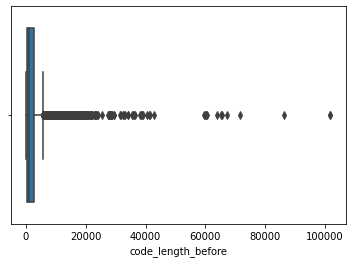

In [87]:
sns.boxplot(x='code_length_before',
            data=functions_data);

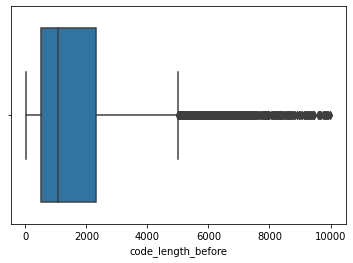

In [88]:
sns.boxplot(x='code_length_before',
            data=functions_data.loc[functions_data['code_length_before'] < 10000]);

Для функций получается, что их длина несколько больше, чем для методов.

Подсчитаем в скольки случаях длина кода не меняется при исправлениях:

In [89]:
(source_code_data['code_length_before'] == source_code_data['code_length_after']).sum()

471

Видно, что для подавляющего большинства длина кода меняется.

Подсчитаем разницу между длиной кода до и после исправления:

In [90]:
source_code_data['code_length_difference'] = source_code_data['code_length_after'] - source_code_data['code_length_before']

Подсчитаем статистики распределения разности:

In [91]:
print(f'Среднее значение разницы длины кода равно {source_code_data["code_length_difference"].mean()}.')
print(f'Медиана разницы длины кода равна {source_code_data["code_length_difference"].median()}.')
print(f'С.к.о разницы длины кода равно {source_code_data["code_length_difference"].std()}.')
print(f'25-й персентиль разницы длины кода равен {source_code_data["code_length_difference"].quantile(q=0.25)}.')
print(f'75-й персентиль разницы длины кода равен {source_code_data["code_length_difference"].quantile(q=0.75)}.')
print(f'90-й персентиль разницы длины кода равен {source_code_data["code_length_difference"].quantile(q=0.95)}.')
print(f'Минимум разницы длины кода равен {source_code_data["code_length_difference"].min()}.')
print(f'Максимум разницы длины кода равен {source_code_data["code_length_difference"].max()}.')

Среднее значение разницы длины кода равно 74.52154368108566.
Медиана разницы длины кода равна 30.0.
С.к.о разницы длины кода равно 345.4440045637827.
25-й персентиль разницы длины кода равен 0.0.
75-й персентиль разницы длины кода равен 118.0.
90-й персентиль разницы длины кода равен 442.0.
Минимум разницы длины кода равен -5659.
Максимум разницы длины кода равен 13314.


# Длина кода без докстрингов и комментариев в символах

In [92]:
source_code_data['code_length_wd_before'] = source_code_data['before_merge_without_docstrings'].apply(lambda x: len(x))
source_code_data['code_length_wd_after'] = source_code_data['after_merge_without_docstrings'].apply(lambda x: len(x))

По коду с ошибками:

In [93]:
print(f'Среднее значение длины сниппетов равно {source_code_data["code_length_wd_before"].mean()}.')
print(f'Медиана длины сниппетов равна {source_code_data["code_length_wd_before"].median()}.')
print(f'С.к.о длины сниппетов равно {source_code_data["code_length_wd_before"].std()}.')
print(f'25-й персентиль длины сниппетов равен {source_code_data["code_length_wd_before"].quantile(q=0.25)}.')
print(f'75-й персентиль длины сниппетов равен {source_code_data["code_length_wd_before"].quantile(q=0.75)}.')
print(f'90-й персентиль длины сниппетов равен {source_code_data["code_length_wd_before"].quantile(q=0.90)}.')
print(f'Минимум длины сниппетов равен {source_code_data["code_length_wd_before"].min()}.')
print(f'Максимум длины сниппетов равен {source_code_data["code_length_wd_before"].max()}.')

Среднее значение длины сниппетов равно 1473.0223070398642.
Медиана длины сниппетов равна 729.0.
С.к.о длины сниппетов равно 3271.6547956796517.
25-й персентиль длины сниппетов равен 335.0.
75-й персентиль длины сниппетов равен 1557.25.
90-й персентиль длины сниппетов равен 3155.100000000002.
Минимум длины сниппетов равен 19.
Максимум длины сниппетов равен 181987.


Теперь отдельно по методам:

In [94]:
methods_data = source_code_data.loc[source_code_data['class_name'].notna()]

In [95]:
print(f'Среднее значение длины сниппетов равно {methods_data["code_length_wd_before"].mean()}.')
print(f'Медиана длины сниппетов равна {methods_data["code_length_wd_before"].median()}.')
print(f'С.к.о длины сниппетов равно {methods_data["code_length_wd_before"].std()}.')
print(f'25-й персентиль длины сниппетов равен {methods_data["code_length_wd_before"].quantile(q=0.25)}.')
print(f'75-й персентиль длины сниппетов равен {methods_data["code_length_wd_before"].quantile(q=0.75)}.')
print(f'90-й персентиль длины сниппетов равен {methods_data["code_length_wd_before"].quantile(q=0.90)}.')
print(f'Минимум длины сниппетов равен {methods_data["code_length_wd_before"].min()}.')
print(f'Максимум длины сниппетов равен {methods_data["code_length_wd_before"].max()}.')

Среднее значение длины сниппетов равно 1252.2307892172782.
Медиана длины сниппетов равна 667.0.
С.к.о длины сниппетов равно 2896.467206549287.
25-й персентиль длины сниппетов равен 306.5.
75-й персентиль длины сниппетов равен 1388.0.
90-й персентиль длины сниппетов равен 2708.800000000001.
Минимум длины сниппетов равен 19.
Максимум длины сниппетов равен 181987.


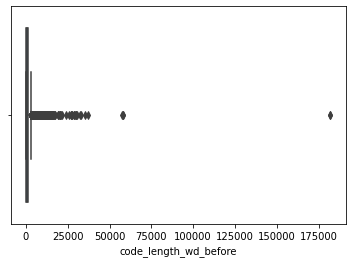

In [96]:
sns.boxplot(x='code_length_wd_before',
            data=methods_data);

Теперь удалим выбросы:

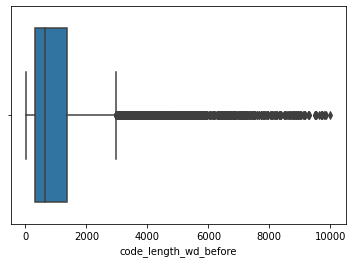

In [97]:
sns.boxplot(x='code_length_wd_before',
            data=methods_data.loc[methods_data['code_length_wd_before'] < 10000]);

Теперь по функциям:

In [98]:
functions_data = source_code_data.loc[source_code_data['class_name'].isna()]

In [99]:
print(f'Среднее значение длины сниппетов равно {functions_data["code_length_wd_before"].mean()}.')
print(f'Медиана длины сниппетов равна {functions_data["code_length_wd_before"].median()}.')
print(f'С.к.о длины сниппетов равно {functions_data["code_length_wd_before"].std()}.')
print(f'25-й персентиль длины сниппетов равен {functions_data["code_length_wd_before"].quantile(q=0.25)}.')
print(f'75-й персентиль длины сниппетов равен {functions_data["code_length_wd_before"].quantile(q=0.75)}.')
print(f'90-й персентиль длины сниппетов равен {functions_data["code_length_wd_before"].quantile(q=0.90)}.')
print(f'Минимум длины сниппетов равен {functions_data["code_length_wd_before"].min()}.')
print(f'Максимум длины сниппетов равен {functions_data["code_length_wd_before"].max()}.')

Среднее значение длины сниппетов равно 1888.3045815516189.
Медиана длины сниппетов равна 861.0.
С.к.о длины сниппетов равно 3846.2756845364424.
25-й персентиль длины сниппетов равен 394.0.
75-й персентиль длины сниппетов равен 1916.0.
90-й персентиль длины сниппетов равен 4114.000000000002.
Минимум длины сниппетов равен 19.
Максимум длины сниппетов равен 100715.


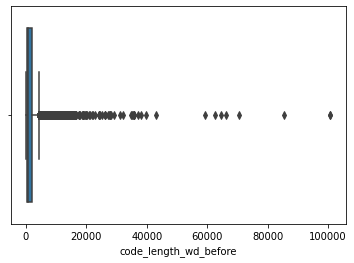

In [100]:
sns.boxplot(x='code_length_wd_before',
            data=functions_data);

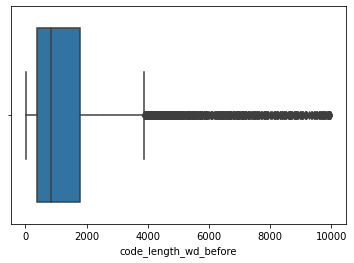

In [101]:
sns.boxplot(x='code_length_wd_before',
            data=functions_data.loc[functions_data['code_length_wd_before'] < 10000]);

Для функций получается, что их длина несколько больше, чем для методов.

Подсчитаем в скольки случаях длина кода не меняется при исправлениях:

In [102]:
(source_code_data['code_length_wd_before'] == source_code_data['code_length_wd_after']).sum()

1014

Видно, что для подавляющего большинства длина кода меняется.

Подсчитаем разницу между длиной кода до и после исправления:

In [103]:
source_code_data['code_length_wd__difference'] = source_code_data['code_length_wd_after'] - source_code_data['code_length_wd_before']

Подсчитаем статистики распределения разности:

In [104]:
print(f'Среднее значение разницы длины кода равно {source_code_data["code_length_wd__difference"].mean()}.')
print(f'Медиана разницы длины кода равна {source_code_data["code_length_wd__difference"].median()}.')
print(f'С.к.о разницы длины кода равно {source_code_data["code_length_wd__difference"].std()}.')
print(f'25-й персентиль разницы длины кода равен {source_code_data["code_length_wd__difference"].quantile(q=0.25)}.')
print(f'75-й персентиль разницы длины кода равен {source_code_data["code_length_wd__difference"].quantile(q=0.75)}.')
print(f'90-й персентиль разницы длины кода равен {source_code_data["code_length_wd__difference"].quantile(q=0.95)}.')
print(f'Минимум разницы длины кода равен {source_code_data["code_length_wd__difference"].min()}.')
print(f'Максимум разницы длины кода равен {source_code_data["code_length_wd__difference"].max()}.')

Среднее значение разницы длины кода равно 55.5540288379983.
Медиана разницы длины кода равна 24.0.
С.к.о разницы длины кода равно 288.05692328074804.
25-й персентиль разницы длины кода равен 0.0.
75-й персентиль разницы длины кода равен 91.0.
90-й персентиль разницы длины кода равен 344.0.
Минимум разницы длины кода равен -5291.
Максимум разницы длины кода равен 12645.


# Распределение по числу аргументов функций и методов



In [105]:
from radon.visitors import ComplexityVisitor
import re

def removeExtraSpaces(snippet):
    number_of_spaces_to_remove = re.search('\S', snippet.split('\n')[0]).start(0)
    return '\n'.join([snippet_line[number_of_spaces_to_remove:] 
                      for snippet_line in snippet.split('\n')])


def refineSnippet(snippet):
    try:
        ComplexityVisitor.from_code(snippet)
        return snippet
    except:
        try:
            snippet_with_removed_extra_spaces = removeExtraSpaces(snippet)
            ComplexityVisitor.from_code(snippet_with_removed_extra_spaces)
            return snippet_with_removed_extra_spaces
        except:
            return np.nan

In [106]:
def getArgumentsCount(snippet):
    for node in ast.parse(snippet).body:
         if isinstance(node, tuple({ast.FunctionDef:'Function',
                                    ast.AsyncFunctionDef:'AsyncFunction'})):
            return len(node.args.args)

In [107]:
source_code_data['before_merge'] = source_code_data['before_merge'].apply(refineSnippet)
source_code_data['after_merge'] = source_code_data['after_merge'].apply(refineSnippet)

In [108]:
source_code_data = source_code_data.loc[source_code_data['before_merge'].notna()]
source_code_data = source_code_data.loc[source_code_data['after_merge'].notna()]

In [109]:
source_code_data['number_of_arguments_before'] = source_code_data['before_merge'].apply(getArgumentsCount)
source_code_data['number_of_arguments_after'] = source_code_data['after_merge'].apply(getArgumentsCount)

По коду с ошибками:

In [110]:
print(f'Среднее значение числа аргументов равно {source_code_data["number_of_arguments_before"].mean()}.')
print(f'Медиана числа аргументов равна {source_code_data["number_of_arguments_before"].median()}.')
print(f'Мода числа аргументов равна {source_code_data["number_of_arguments_before"].mode()[0]} с частотой {source_code_data["number_of_arguments_before"].value_counts()[0]}.')
print(f'С.к.о числа аргументов равно {source_code_data["number_of_arguments_before"].std()}.')
print(f'25-й персентиль числа аргументов равен {source_code_data["number_of_arguments_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа аргументов равен {source_code_data["number_of_arguments_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа аргументов равен {source_code_data["number_of_arguments_before"].quantile(q=0.90)}.')
print(f'Минимум числа аргументов равен {source_code_data["number_of_arguments_before"].min()}.')
print(f'Максимум числа аргументов равен {source_code_data["number_of_arguments_before"].max()}.')

Среднее значение числа аргументов равно 2.9901406655050784.
Медиана числа аргументов равна 2.0.
Мода числа аргументов равна 2 с частотой 1264.
С.к.о числа аргументов равно 3.425869141178274.
25-й персентиль числа аргументов равен 1.0.
75-й персентиль числа аргументов равен 4.0.
90-й персентиль числа аргументов равен 6.0.
Минимум числа аргументов равен 0.
Максимум числа аргументов равен 75.


Наиболее частое число аргументов равно 2.

Теперь отдельно по методам:

In [111]:
methods_data = source_code_data.loc[source_code_data['class_name'].notna()]

In [112]:
print(f'Среднее значение числа аргументов равно {methods_data["number_of_arguments_before"].mean()}.')
print(f'Медиана числа аргументов равна {methods_data["number_of_arguments_before"].median()}.')
print(f'Мода числа аргументов равна {methods_data["number_of_arguments_before"].mode()[0]} с частотой {methods_data["number_of_arguments_before"].value_counts()[0]}.')
print(f'С.к.о числа аргументов равно {methods_data["number_of_arguments_before"].std()}.')
print(f'25-й персентиль числа аргументов равен {methods_data["number_of_arguments_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа аргументов равен {methods_data["number_of_arguments_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа аргументов равен {methods_data["number_of_arguments_before"].quantile(q=0.90)}.')
print(f'Минимум числа аргументов равен {methods_data["number_of_arguments_before"].min()}.')
print(f'Максимум числа аргументов равен {methods_data["number_of_arguments_before"].max()}.')

Среднее значение числа аргументов равно 2.8933342021241937.
Медиана числа аргументов равна 2.0.
Мода числа аргументов равна 2 с частотой 180.
С.к.о числа аргументов равно 2.7662813541337212.
25-й персентиль числа аргументов равен 1.0.
75-й персентиль числа аргументов равен 3.0.
90-й персентиль числа аргументов равен 5.0.
Минимум числа аргументов равен 0.
Максимум числа аргументов равен 73.


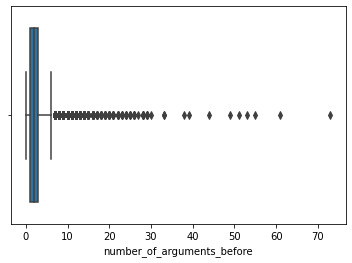

In [113]:
sns.boxplot(x='number_of_arguments_before',
            data=methods_data);

Теперь удалим выбросы:

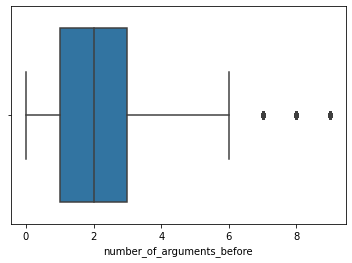

In [114]:
sns.boxplot(x='number_of_arguments_before',
            data=methods_data.loc[methods_data['number_of_arguments_before'] < 10]);

Теперь по функциям:

In [115]:
functions_data = source_code_data.loc[source_code_data['class_name'].isna()]

In [116]:
print(f'Среднее значение числа аргументов равно {functions_data["number_of_arguments_before"].mean()}.')
print(f'Медиана числа аргументов равна {functions_data["number_of_arguments_before"].median()}.')
print(f'Мода числа аргументов равна {functions_data["number_of_arguments_before"].mode()[0]} с частотой {functions_data["number_of_arguments_before"].value_counts()[0]}.')
print(f'С.к.о числа аргументов равно {functions_data["number_of_arguments_before"].std()}.')
print(f'25-й персентиль числа аргументов равен {functions_data["number_of_arguments_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа аргументов равен {functions_data["number_of_arguments_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа аргументов равен {functions_data["number_of_arguments_before"].quantile(q=0.90)}.')
print(f'Минимум числа аргументов равен {functions_data["number_of_arguments_before"].min()}.')
print(f'Максимум числа аргументов равен {functions_data["number_of_arguments_before"].max()}.')

Среднее значение числа аргументов равно 3.1716764418377323.
Медиана числа аргументов равна 2.0.
Мода числа аргументов равна 1 с частотой 1084.
С.к.о числа аргументов равно 4.398512666185681.
25-й персентиль числа аргументов равен 1.0.
75-й персентиль числа аргументов равен 4.0.
90-й персентиль числа аргументов равен 7.0.
Минимум числа аргументов равен 0.
Максимум числа аргументов равен 75.


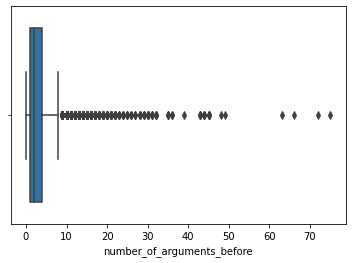

In [117]:
sns.boxplot(x='number_of_arguments_before',
            data=functions_data);

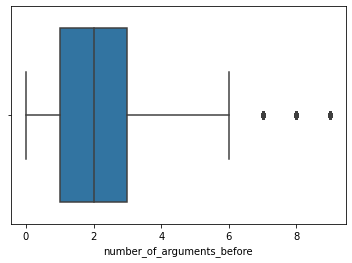

In [118]:
sns.boxplot(x='number_of_arguments_before',
            data=functions_data.loc[functions_data['number_of_arguments_before'] < 10]);

Для функций получается, что число аргументов несколько больше, чем для методов, особенно если учитывать, что у обычных методов присутствует аргумент `self`.

Подсчитаем в скольки случаях число аргументов не меняется при исправлениях:

In [119]:
(source_code_data['number_of_arguments_before'] == source_code_data['number_of_arguments_after']).sum()

22085

Видно, что для подавляющего большинства число аргументов не меняется.

Подсчитаем разницу между числом аргументов до и после исправления:

In [120]:
source_code_data['number_of_arguments_difference'] = source_code_data['number_of_arguments_after'] - source_code_data['number_of_arguments_before']

Подсчитаем статистики распределения разности:

In [121]:
print(f'Среднее значение разницы числа аргументов равно {source_code_data["number_of_arguments_difference"].mean()}.')
print(f'Медиана разницы числа аргументов равна {source_code_data["number_of_arguments_difference"].median()}.')
print(f'Мода разницы числа аргументов равна {source_code_data["number_of_arguments_difference"].mode()[0]} с частотой {source_code_data["number_of_arguments_difference"].value_counts()[0]}.')
print(f'С.к.о разницы числа аргументов равно {source_code_data["number_of_arguments_difference"].std()}.')
print(f'25-й персентиль разницы числа аргументов равен {source_code_data["number_of_arguments_difference"].quantile(q=0.25)}.')
print(f'75-й персентиль разницы числа аргументов равен {source_code_data["number_of_arguments_difference"].quantile(q=0.75)}.')
print(f'90-й персентиль разницы числа аргументов равен {source_code_data["number_of_arguments_difference"].quantile(q=0.95)}.')
print(f'Минимум разницы числа аргументов равен {source_code_data["number_of_arguments_difference"].min()}.')
print(f'Максимум разницы числа аргументов равен {source_code_data["number_of_arguments_difference"].max()}.')

Среднее значение разницы числа аргументов равно 0.031957842845607924.
Медиана разницы числа аргументов равна 0.0.
Мода разницы числа аргументов равна 0 с частотой 22085.
С.к.о разницы числа аргументов равно 0.386665087117281.
25-й персентиль разницы числа аргументов равен 0.0.
75-й персентиль разницы числа аргументов равен 0.0.
90-й персентиль разницы числа аргументов равен 0.0.
Минимум разницы числа аргументов равен -9.
Максимум разницы числа аргументов равен 11.


# Распределение по числу присвоений в реализации функций и методов

В коде встречаются три типа операций присвоения значений переменной: 

- простое присвоение a=b, (a, b) = f(x)
- присвоение значения атрибуту a.x=5 или a.b.c.d = 7
- присвоение значение индексированному элементу a.b[x].c=7

Ниже анализируются признаки, соответствующие числу присвоений первого и второго типа.

Функции, вычисляют левую часть выражения присвоения первого и второго типа.

In [122]:
def checkOnSimpleAssignment(node):
    names = set()
    for item in node.targets:
        if isinstance(item, ast.Tuple):
            for subitem in item.elts:
                if isinstance(subitem, ast.Name):
                    names.add(subitem.id)
        elif isinstance(item, ast.Name):
            names.add(item.id)
    return names

In [123]:
def checkOnSimpleAttributeAssignment(node):
    names = set()
    for item in node.targets:
        if isinstance(item, ast.Tuple):
            for subitem in item.elts:
                if isinstance(subitem, ast.Attribute):
                    term = ''
                    while isinstance(subitem, ast.Attribute):
                        term = subitem.attr + '.' + term
                        subitem = subitem.value
                    if isinstance(subitem, ast.Name):
                        term = subitem.id + '.' + term.strip('.')
                        names.add(term)
        elif isinstance(item, ast.Attribute):
            term = ''
            while isinstance(item, ast.Attribute):
                term = item.attr + '.' + term
                item = item.value
            if isinstance(item, ast.Name):
                term = item.id + '.' + term.strip('.')
                names.add(term)
    return names

Описывается visitor-класс, который позволяет обходит AST-дерево и ищет все узлы, отвечающие операции присвоения.

In [124]:
class VisitSimpleAssigments(ast.NodeVisitor):
    def __init__(self):
        self.simple_assignments = set()
        self.number_of_simple_assignments = 0
        super().__init__()
        
    def generic_visit(self, node):
        if isinstance(node, ast.Assign):
            self.simple_assignments |= checkOnSimpleAssignment(node)
            self.number_of_simple_assignments = len(self.simple_assignments)
        ast.NodeVisitor.generic_visit(self, node)

In [125]:
class VisitAttributeAssigments(ast.NodeVisitor):
    def __init__(self):
        self.attribute_assignments = set()
        self.number_of_attribute_assignments = 0
        super().__init__()
        
    def generic_visit(self, node):
        if isinstance(node, ast.Assign):
            self.attribute_assignments |= checkOnSimpleAttributeAssignment(node)
            self.number_of_attribute_assignments = len(self.attribute_assignments)
        ast.NodeVisitor.generic_visit(self, node)

Функции вычисления количества присвоений первого и второго типа.

In [126]:
def getSimpleAssignmentsCount(snippet):
    visit_simple_assignments = VisitSimpleAssigments()
    visit_simple_assignments.visit(ast.parse(snippet))
    return visit_simple_assignments.number_of_simple_assignments

In [127]:
def getSimpleAttributeAssignmentsCount(snippet):
    visit_attribute_assignments = VisitAttributeAssigments()
    visit_attribute_assignments.visit(ast.parse(snippet))
    return visit_attribute_assignments.number_of_attribute_assignments

Подсчитаем значения признаков для кода с ошибками:

In [128]:
source_code_data['number_of_distinct_simple_assignments_before'] = source_code_data['before_merge'].apply(getSimpleAssignmentsCount)
source_code_data['number_of_distinct_simple_assignments_after'] = source_code_data['after_merge'].apply(getSimpleAssignmentsCount)
source_code_data['number_of_distinct_attribute_assignments_before'] = source_code_data['before_merge'].apply(getSimpleAttributeAssignmentsCount)
source_code_data['number_of_distinct_attribute_assignments_after'] = source_code_data['after_merge'].apply(getSimpleAttributeAssignmentsCount)

## Распределение по числу простых присвоений

Подсчитаем статистики по числу присвоений первого типа по коду с ошибками:

In [129]:
print(f'Среднее значение числа простых присвоений равно {source_code_data["number_of_distinct_simple_assignments_before"].mean()}.')
print(f'Медиана числа простых присвоений равна {source_code_data["number_of_distinct_simple_assignments_before"].median()}.')
print(f'Мода числа простых присвоений равна {source_code_data["number_of_distinct_simple_assignments_before"].mode()[0]} с частотой {source_code_data["number_of_distinct_simple_assignments_before"].value_counts()[0]}.')
print(f'С.к.о числа простых присвоений равно {source_code_data["number_of_distinct_simple_assignments_before"].std()}.')
print(f'25-й персентиль числа простых присвоений равен {source_code_data["number_of_distinct_simple_assignments_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа простых присвоений равен {source_code_data["number_of_distinct_simple_assignments_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа простых присвоений равен {source_code_data["number_of_distinct_simple_assignments_before"].quantile(q=0.90)}.')
print(f'Минимум числа простых присвоений равен {source_code_data["number_of_distinct_simple_assignments_before"].min()}.')
print(f'Максимум числа простых присвоений равен {source_code_data["number_of_distinct_simple_assignments_before"].max()}.')

Среднее значение числа простых присвоений равно 5.213548085504229.
Медиана числа простых присвоений равна 3.0.
Мода числа простых присвоений равна 0 с частотой 4755.
С.к.о числа простых присвоений равно 8.912160286483026.
25-й персентиль числа простых присвоений равен 1.0.
75-й персентиль числа простых присвоений равен 6.0.
90-й персентиль числа простых присвоений равен 12.0.
Минимум числа простых присвоений равен 0.
Максимум числа простых присвоений равен 432.


Теперь по методам:

In [130]:
methods_data = source_code_data.loc[source_code_data['class_name'].notna()]

In [131]:
print(f'Среднее значение числа простых присвоений равно {methods_data["number_of_distinct_simple_assignments_before"].mean()}.')
print(f'Медиана числа простых присвоений равна {methods_data["number_of_distinct_simple_assignments_before"].median()}.')
print(f'Мода числа простых присвоений равна {methods_data["number_of_distinct_simple_assignments_before"].mode()[0]} с частотой {methods_data["number_of_distinct_simple_assignments_before"].value_counts()[0]}.')
print(f'С.к.о числа простых присвоений равно {methods_data["number_of_distinct_simple_assignments_before"].std()}.')
print(f'25-й персентиль числа простых присвоений равен {methods_data["number_of_distinct_simple_assignments_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа простых присвоений равен {methods_data["number_of_distinct_simple_assignments_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа простых присвоений равен {methods_data["number_of_distinct_simple_assignments_before"].quantile(q=0.90)}.')
print(f'Минимум числа простых присвоений равен {methods_data["number_of_distinct_simple_assignments_before"].min()}.')
print(f'Максимум числа простых присвоений равен {methods_data["number_of_distinct_simple_assignments_before"].max()}.')

Среднее значение числа простых присвоений равно 4.3069003714080925.
Медиана числа простых присвоений равна 2.0.
Мода числа простых присвоений равна 0 с частотой 3672.
С.к.о числа простых присвоений равно 6.480743208379045.
25-й персентиль числа простых присвоений равен 1.0.
75-й персентиль числа простых присвоений равен 6.0.
90-й персентиль числа простых присвоений равен 11.0.
Минимум числа простых присвоений равен 0.
Максимум числа простых присвоений равен 100.


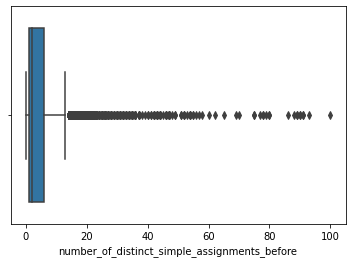

In [132]:
sns.boxplot(x='number_of_distinct_simple_assignments_before',
            data=methods_data);

Удалим выбросы:

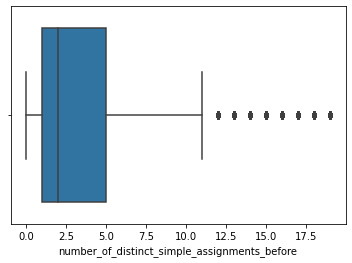

In [133]:
sns.boxplot(x='number_of_distinct_simple_assignments_before',
            data=methods_data.loc[methods_data['number_of_distinct_simple_assignments_before'] < 20]);

Теперь по функциям:

In [134]:
functions_data = source_code_data.loc[source_code_data['class_name'].isna()]

In [135]:
print(f'Среднее значение числа простых присвоений равно {functions_data["number_of_distinct_simple_assignments_before"].mean()}.')
print(f'Медиана числа простых присвоений равна {functions_data["number_of_distinct_simple_assignments_before"].median()}.')
print(f'Мода числа простых присвоений равна {functions_data["number_of_distinct_simple_assignments_before"].mode()[0]} с частотой {functions_data["number_of_distinct_simple_assignments_before"].value_counts()[0]}.')
print(f'С.к.о числа простых присвоений равно {functions_data["number_of_distinct_simple_assignments_before"].std()}.')
print(f'25-й персентиль числа простых присвоений равен {functions_data["number_of_distinct_simple_assignments_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа простых присвоений равен {functions_data["number_of_distinct_simple_assignments_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа простых присвоений равен {functions_data["number_of_distinct_simple_assignments_before"].quantile(q=0.90)}.')
print(f'Минимум числа простых присвоений равен {functions_data["number_of_distinct_simple_assignments_before"].min()}.')
print(f'Максимум числа простых присвоений равен {functions_data["number_of_distinct_simple_assignments_before"].max()}.')

Среднее значение числа простых присвоений равно 6.913734115347019.
Медиана числа простых присвоений равна 4.0.
Мода числа простых присвоений равна 0 с частотой 1083.
С.к.о числа простых присвоений равно 12.049548893339836.
25-й персентиль числа простых присвоений равен 2.0.
75-й персентиль числа простых присвоений равен 8.0.
90-й персентиль числа простых присвоений равен 16.0.
Минимум числа простых присвоений равен 0.
Максимум числа простых присвоений равен 432.


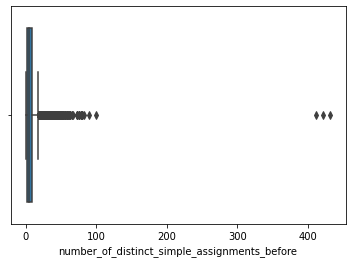

In [136]:
sns.boxplot(x='number_of_distinct_simple_assignments_before',
            data=functions_data);

Удалим выбросы:

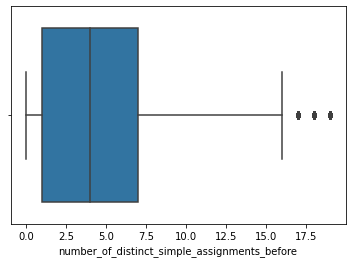

In [137]:
sns.boxplot(x='number_of_distinct_simple_assignments_before',
            data=functions_data.loc[functions_data['number_of_distinct_simple_assignments_before'] < 20]);

В функциях количество простых переменных чуть больше.

Подсчитаем число раз, когда число простых переменных не меняется при исправлениях:

In [138]:
(source_code_data['number_of_distinct_simple_assignments_before'] == source_code_data['number_of_distinct_simple_assignments_after']).sum()

18589

У подавляющего большинства сниппетов число простых переменных не меняется.

Подсчитаем разницу между числом простых переменных до и после исправления:

In [139]:
source_code_data['number_of_distinct_assignments_difference'] = (source_code_data['number_of_distinct_simple_assignments_after'] - 
                                                                 source_code_data['number_of_distinct_simple_assignments_before'])

Подсчитаем статистики распределения разности:

In [140]:
print(f'Среднее значение разницы числа простых присвоений равно {source_code_data["number_of_distinct_assignments_difference"].mean()}.')
print(f'Медиана разницы числа простых присвоений равна {source_code_data["number_of_distinct_assignments_difference"].median()}.')
print(f'Мода разницы числа простых присвоений равна {source_code_data["number_of_distinct_assignments_difference"].mode()[0]} с частотой {source_code_data["number_of_distinct_assignments_difference"].value_counts()[0]}.')
print(f'С.к.о разницы числа простых присвоений равно {source_code_data["number_of_distinct_assignments_difference"].std()}.')
print(f'25-й персентиль разницы числа простых присвоений равен {source_code_data["number_of_distinct_assignments_difference"].quantile(q=0.25)}.')
print(f'75-й персентиль разницы числа простых присвоений равен {source_code_data["number_of_distinct_assignments_difference"].quantile(q=0.75)}.')
print(f'90-й персентиль разницы числа простых присвоений равен {source_code_data["number_of_distinct_assignments_difference"].quantile(q=0.95)}.')
print(f'Минимум разницы числа простых присвоений равен {source_code_data["number_of_distinct_assignments_difference"].min()}.')
print(f'Максимум разницы числа простых присвоений равен {source_code_data["number_of_distinct_assignments_difference"].max()}.')

Среднее значение разницы числа простых присвоений равно 0.12825634269686795.
Медиана разницы числа простых присвоений равна 0.0.
Мода разницы числа простых присвоений равна 0 с частотой 18589.
С.к.о разницы числа простых присвоений равно 1.229522837137973.
25-й персентиль разницы числа простых присвоений равен 0.0.
75-й персентиль разницы числа простых присвоений равен 0.0.
90-й персентиль разницы числа простых присвоений равен 1.0.
Минимум разницы числа простых присвоений равен -23.
Максимум разницы числа простых присвоений равен 58.


## Распределение по числу простых присвоений атрибутам

Подсчитаем статистики по числу присвоений атрибутам по коду с ошибками:

In [141]:
print(f'Среднее значение числа присвоений атрибутам равно {source_code_data["number_of_distinct_attribute_assignments_before"].mean()}.')
print(f'Медиана числа присвоений атрибутам равна {source_code_data["number_of_distinct_attribute_assignments_before"].median()}.')
print(f'Мода числа присвоений атрибутам равна {source_code_data["number_of_distinct_attribute_assignments_before"].mode()[0]} с частотой {source_code_data["number_of_distinct_attribute_assignments_before"].value_counts()[0]}.')
print(f'С.к.о числа присвоений атрибутам равно {source_code_data["number_of_distinct_attribute_assignments_before"].std()}.')
print(f'25-й персентиль числа присвоений атрибутам равен {source_code_data["number_of_distinct_attribute_assignments_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа присвоений атрибутам равен {source_code_data["number_of_distinct_attribute_assignments_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа присвоений атрибутам равен {source_code_data["number_of_distinct_attribute_assignments_before"].quantile(q=0.90)}.')
print(f'Минимум числа присвоений атрибутам равен {source_code_data["number_of_distinct_attribute_assignments_before"].min()}.')
print(f'Максимум числа присвоений атрибутам равен {source_code_data["number_of_distinct_attribute_assignments_before"].max()}.')

Среднее значение числа присвоений атрибутам равно 1.1754281585992945.
Медиана числа присвоений атрибутам равна 0.0.
Мода числа присвоений атрибутам равна 0 с частотой 17502.
С.к.о числа присвоений атрибутам равно 6.203092851540449.
25-й персентиль числа присвоений атрибутам равен 0.0.
75-й персентиль числа присвоений атрибутам равен 1.0.
90-й персентиль числа присвоений атрибутам равен 3.0.
Минимум числа присвоений атрибутам равен 0.
Максимум числа присвоений атрибутам равен 433.


Теперь по методам:

In [142]:
methods_data = source_code_data.loc[source_code_data['class_name'].notna()]

In [143]:
print(f'Среднее значение числа присвоений атрибутам равно {methods_data["number_of_distinct_attribute_assignments_before"].mean()}.')
print(f'Медиана числа присвоений атрибутам равна {methods_data["number_of_distinct_attribute_assignments_before"].median()}.')
print(f'Мода числа присвоений атрибутам равна {methods_data["number_of_distinct_attribute_assignments_before"].mode()[0]} с частотой {methods_data["number_of_distinct_attribute_assignments_before"].value_counts()[0]}.')
print(f'С.к.о числа присвоений атрибутам равно {methods_data["number_of_distinct_attribute_assignments_before"].std()}.')
print(f'25-й персентиль числа присвоений атрибутам равен {methods_data["number_of_distinct_attribute_assignments_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа присвоений атрибутам равен {methods_data["number_of_distinct_attribute_assignments_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа присвоений атрибутам равен {methods_data["number_of_distinct_attribute_assignments_before"].quantile(q=0.90)}.')
print(f'Минимум числа присвоений атрибутам равен {methods_data["number_of_distinct_attribute_assignments_before"].min()}.')
print(f'Максимум числа присвоений атрибутам равен {methods_data["number_of_distinct_attribute_assignments_before"].max()}.')

Среднее значение числа присвоений атрибутам равно 1.5902130709584936.
Медиана числа присвоений атрибутам равна 0.0.
Мода числа присвоений атрибутам равна 0 с частотой 10272.
С.к.о числа присвоений атрибутам равно 7.5059030160419855.
25-й персентиль числа присвоений атрибутам равен 0.0.
75-й персентиль числа присвоений атрибутам равен 1.0.
90-й персентиль числа присвоений атрибутам равен 4.0.
Минимум числа присвоений атрибутам равен 0.
Максимум числа присвоений атрибутам равен 433.


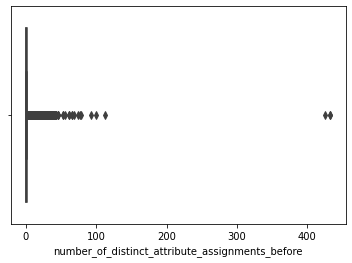

In [144]:
sns.boxplot(x='number_of_distinct_attribute_assignments_before',
            data=methods_data);

Удалим выбросы:

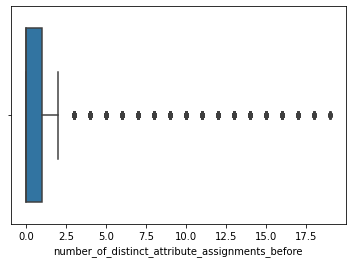

In [145]:
sns.boxplot(x='number_of_distinct_attribute_assignments_before',
            data=methods_data.loc[methods_data['number_of_distinct_attribute_assignments_before'] < 20]);

В методах большая часть не содержит присвоений атрибутам.

Теперь по функциям:

In [146]:
functions_data = source_code_data.loc[source_code_data['class_name'].isna()]

In [147]:
print(f'Среднее значение числа присвоений атрибутам равно {functions_data["number_of_distinct_attribute_assignments_before"].mean()}.')
print(f'Медиана числа присвоений атрибутам равна {functions_data["number_of_distinct_attribute_assignments_before"].median()}.')
print(f'Мода числа присвоений атрибутам равна {functions_data["number_of_distinct_attribute_assignments_before"].mode()[0]} с частотой {functions_data["number_of_distinct_attribute_assignments_before"].value_counts()[0]}.')
print(f'С.к.о числа присвоений атрибутам равно {functions_data["number_of_distinct_attribute_assignments_before"].std()}.')
print(f'25-й персентиль числа присвоений атрибутам равен {functions_data["number_of_distinct_attribute_assignments_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа присвоений атрибутам равен {functions_data["number_of_distinct_attribute_assignments_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа присвоений атрибутам равен {functions_data["number_of_distinct_attribute_assignments_before"].quantile(q=0.90)}.')
print(f'Минимум числа присвоений атрибутам равен {functions_data["number_of_distinct_attribute_assignments_before"].min()}.')
print(f'Максимум числа присвоений атрибутам равен {functions_data["number_of_distinct_attribute_assignments_before"].max()}.')

Среднее значение числа присвоений атрибутам равно 0.39760508308895404.
Медиана числа присвоений атрибутам равна 0.0.
Мода числа присвоений атрибутам равна 0 с частотой 7230.
С.к.о числа присвоений атрибутам равно 2.015223530528176.
25-й персентиль числа присвоений атрибутам равен 0.0.
75-й персентиль числа присвоений атрибутам равен 0.0.
90-й персентиль числа присвоений атрибутам равен 1.0.
Минимум числа присвоений атрибутам равен 0.
Максимум числа присвоений атрибутам равен 55.


В функциях также мало присвоений атрибутам. Их даже еще меньше, чем у методов.

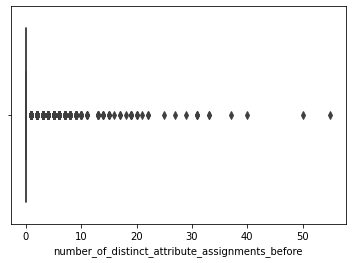

In [148]:
sns.boxplot(x='number_of_distinct_attribute_assignments_before',
            data=functions_data);

Удалим выбросы:

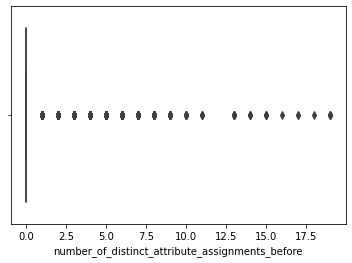

In [149]:
sns.boxplot(x='number_of_distinct_attribute_assignments_before',
            data=functions_data.loc[functions_data['number_of_distinct_attribute_assignments_before'] < 20]);

В функциях количество присвоений атрибутам меньше, поскольку отсутствуют присвоения типа `self.a=x`.

Подсчитаем число раз, когда число присвоений атрибутам не меняется при исправлениях:

In [150]:
(source_code_data['number_of_distinct_attribute_assignments_before'] == source_code_data['number_of_distinct_attribute_assignments_after']).sum()

22008

У подавляющего большинства сниппетов число присвоений атрибутам не меняется.

Подсчитаем разницу между числом присвоений атрибутам до и после исправления:

In [151]:
source_code_data['number_of_distinct_attribute_assignments_difference'] = (source_code_data['number_of_distinct_attribute_assignments_after'] - 
                                                                           source_code_data['number_of_distinct_attribute_assignments_before'])

Подсчитаем статистики распределения разности:

In [152]:
print(f'Среднее значение разницы числа присвоений атрибутам равно {source_code_data["number_of_distinct_attribute_assignments_difference"].mean()}.')
print(f'Медиана разницы числа присвоений атрибутам равна {source_code_data["number_of_distinct_attribute_assignments_difference"].median()}.')
print(f'Мода разницы числа присвоений атрибутам равна {source_code_data["number_of_distinct_attribute_assignments_difference"].mode()[0]} с частотой {source_code_data["number_of_distinct_attribute_assignments_difference"].value_counts()[0]}')
print(f'С.к.о разницы числа присвоений атрибутам равно {source_code_data["number_of_distinct_attribute_assignments_difference"].std()}.')
print(f'25-й персентиль разницы числа присвоений атрибутам равен {source_code_data["number_of_distinct_attribute_assignments_difference"].quantile(q=0.25)}.')
print(f'75-й персентиль разницы числа присвоений атрибутам равен {source_code_data["number_of_distinct_attribute_assignments_difference"].quantile(q=0.75)}.')
print(f'90-й персентиль разницы числа присвоений атрибутам равен {source_code_data["number_of_distinct_attribute_assignments_difference"].quantile(q=0.95)}.')
print(f'Минимум разницы числа присвоений атрибутам равен {source_code_data["number_of_distinct_attribute_assignments_difference"].min()}.')
print(f'Максимум разницы числа присвоений атрибутам равен {source_code_data["number_of_distinct_attribute_assignments_difference"].max()}.')

Среднее значение разницы числа присвоений атрибутам равно 0.03076792316518635.
Медиана разницы числа присвоений атрибутам равна 0.0.
Мода разницы числа присвоений атрибутам равна 0 с частотой 22008
С.к.о разницы числа присвоений атрибутам равно 0.4688206226103995.
25-й персентиль разницы числа присвоений атрибутам равен 0.0.
75-й персентиль разницы числа присвоений атрибутам равен 0.0.
90-й персентиль разницы числа присвоений атрибутам равен 0.0.
Минимум разницы числа присвоений атрибутам равен -14.
Максимум разницы числа присвоений атрибутам равен 16.


# Распределение по числу вызовов функций



In [153]:
def checkOnFunctionCall(node):
    names = []
    if isinstance(node.func, ast.Name):
        names.append(node.func.id)
    elif isinstance(node.func, ast.Attribute) or isinstance(node.func, ast.Subscript):
        term = ''
        item = node.func
        while isinstance(item, ast.Attribute) or isinstance(item, ast.Subscript):
            if isinstance(item, ast.Attribute):
                term = item.attr + '.' + term
                item = item.value
            elif isinstance(item, ast.Subscript):
                item = item.value
        if isinstance(item, ast.Name):
            term = item.id + '.' + term
        names.append(term.strip('.'))
    return names

Описывается visitor-класс, который позволяет обходит AST-дерево и ищет все узлы, отвечающие операции вызова функции.

In [154]:
class VisitFunctionCalls(ast.NodeVisitor):
    def __init__(self):
        self.function_calls = []
        self.number_function_calls = 0
        super().__init__()
        
    def generic_visit(self, node):
        if isinstance(node, ast.Call):
            self.function_calls += checkOnFunctionCall(node)
            self.number_function_calls = len(self.function_calls)
        ast.NodeVisitor.generic_visit(self, node)

In [155]:
def getFunctionCallCount(snippet):
    visit_function_calls = VisitFunctionCalls()
    visit_function_calls.visit(ast.parse(snippet))
    return visit_function_calls.number_function_calls

Подсчитаем количество вызовов функций:

In [156]:
source_code_data['number_of_function_calls_before'] = source_code_data['before_merge'].apply(getFunctionCallCount)
source_code_data['number_of_function_calls_after'] = source_code_data['after_merge'].apply(getFunctionCallCount)

Подсчитаем статистики по числу вызовов функций по коду с ошибками:

In [157]:
print(f'Среднее значение числа вызовов функций равно {source_code_data["number_of_function_calls_before"].mean()}.')
print(f'Медиана числа вызовов функций равна {source_code_data["number_of_function_calls_before"].median()}.')
print(f'Мода числа вызовов функций равна {source_code_data["number_of_function_calls_before"].mode()[0]} с частотой {source_code_data["number_of_function_calls_before"].value_counts()[0]}.')
print(f'С.к.о числа вызовов функций равно {source_code_data["number_of_function_calls_before"].std()}.')
print(f'25-й персентиль числа вызовов функций равен {source_code_data["number_of_function_calls_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа вызовов функций равен {source_code_data["number_of_function_calls_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа вызовов функций равен {source_code_data["number_of_function_calls_before"].quantile(q=0.90)}.')
print(f'Минимум числа вызовов функций равен {source_code_data["number_of_function_calls_before"].min()}.')
print(f'Максимум числа вызовов функций равен {source_code_data["number_of_function_calls_before"].max()}.')

Среднее значение числа вызовов функций равно 15.735455356763419.
Медиана числа вызовов функций равна 8.0.
Мода числа вызовов функций равна 2 с частотой 605.
С.к.о числа вызовов функций равно 29.54306372217464.
25-й персентиль числа вызовов функций равен 4.0.
75-й персентиль числа вызовов функций равен 18.0.
90-й персентиль числа вызовов функций равен 34.0.
Минимум числа вызовов функций равен 0.
Максимум числа вызовов функций равен 1080.


Теперь по методам:

In [158]:
methods_data = source_code_data.loc[source_code_data['class_name'].notna()]

In [159]:
print(f'Среднее значение числа вызовов функций равно {methods_data["number_of_function_calls_before"].mean()}.')
print(f'Медиана числа вызовов функций равна {methods_data["number_of_function_calls_before"].median()}.')
print(f'Мода числа вызовов функций равна {methods_data["number_of_function_calls_before"].mode()[0]} с частотой {methods_data["number_of_function_calls_before"].value_counts()[0]}.')
print(f'С.к.о числа вызовов функций равно {methods_data["number_of_function_calls_before"].std()}.')
print(f'25-й персентиль числа вызовов функций равен {methods_data["number_of_function_calls_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа вызовов функций равен {methods_data["number_of_function_calls_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа вызовов функций равен {methods_data["number_of_function_calls_before"].quantile(q=0.90)}.')
print(f'Минимум числа вызовов функций равен {methods_data["number_of_function_calls_before"].min()}.')
print(f'Максимум числа вызовов функций равен {methods_data["number_of_function_calls_before"].max()}.')

Среднее значение числа вызовов функций равно 13.41291457613866.
Медиана числа вызовов функций равна 8.0.
Мода числа вызовов функций равна 2 с частотой 458.
С.к.о числа вызовов функций равно 22.550787432731582.
25-й персентиль числа вызовов функций равен 3.0.
75-й персентиль числа вызовов функций равен 16.0.
90-й персентиль числа вызовов функций равен 30.0.
Минимум числа вызовов функций равен 0.
Максимум числа вызовов функций равен 748.


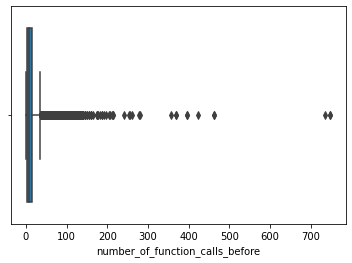

In [160]:
sns.boxplot(x='number_of_function_calls_before',
            data=methods_data);

Удалим выбросы:

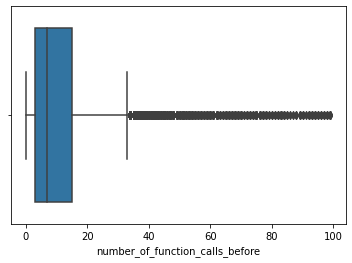

In [161]:
sns.boxplot(x='number_of_function_calls_before',
            data=methods_data.loc[methods_data['number_of_function_calls_before'] < 100]);

Теперь по функциям:

In [162]:
functions_data = source_code_data.loc[source_code_data['class_name'].isna()]

In [163]:
print(f'Среднее значение числа вызовов функций равно {functions_data["number_of_function_calls_before"].mean()}.')
print(f'Медиана числа вызовов функций равна {functions_data["number_of_function_calls_before"].median()}.')
print(f'Мода числа вызовов функций равна {functions_data["number_of_function_calls_before"].mode()[0]} с частотой {functions_data["number_of_function_calls_before"].value_counts()[0]}.')
print(f'С.к.о числа вызовов функций равно {functions_data["number_of_function_calls_before"].std()}.')
print(f'25-й персентиль числа вызовов функций равен {functions_data["number_of_function_calls_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа вызовов функций равен {functions_data["number_of_function_calls_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа вызовов функций равен {functions_data["number_of_function_calls_before"].quantile(q=0.90)}.')
print(f'Минимум числа вызовов функций равен {functions_data["number_of_function_calls_before"].min()}.')
print(f'Максимум числа вызовов функций равен {functions_data["number_of_function_calls_before"].max()}.')

Среднее значение числа вызовов функций равно 20.09078690127077.
Медиана числа вызовов функций равна 10.0.
Мода числа вызовов функций равна 4 с частотой 147.
С.к.о числа вызовов функций равно 39.075781798001934.
25-й персентиль числа вызовов функций равен 4.0.
75-й персентиль числа вызовов функций равен 21.0.
90-й персентиль числа вызовов функций равен 44.0.
Минимум числа вызовов функций равен 0.
Максимум числа вызовов функций равен 1080.


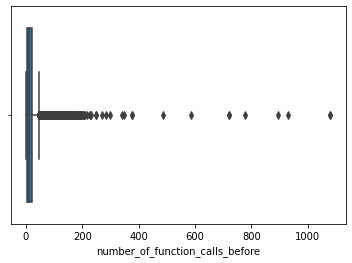

In [164]:
sns.boxplot(x='number_of_function_calls_before',
            data=functions_data);

Удалим выбросы:

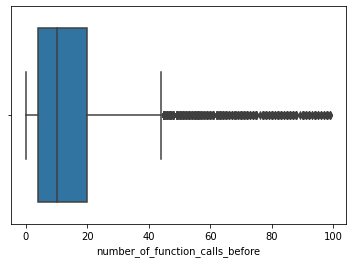

In [165]:
sns.boxplot(x='number_of_function_calls_before',
            data=functions_data.loc[functions_data['number_of_function_calls_before'] < 100]);

В функциях количество вызовов функций больше, чем в методах.

Подсчитаем число раз, когда число вызовов функций не меняется при исправлениях:

In [166]:
(source_code_data['number_of_function_calls_before'] == source_code_data['number_of_function_calls_after']).sum()

11624

У меньше, чем у половины сниппетов число вызовов функций не меняется.

Подсчитаем разницу между числом вызовов функций до и после исправления:

In [167]:
source_code_data['number_of_function_calls_difference'] = (source_code_data['number_of_function_calls_after'] - 
                                                           source_code_data['number_of_function_calls_before'])

Подсчитаем статистики распределения разности:

In [168]:
print(f'Среднее значение разницы числа вызовов функций равно {source_code_data["number_of_function_calls_difference"].mean()}.')
print(f'Медиана разницы числа вызовов функций равна {source_code_data["number_of_function_calls_difference"].median()}.')
print(f'Мода разницы числа вызовов функций равна {source_code_data["number_of_function_calls_difference"].mode()[0]} с частотой {source_code_data["number_of_function_calls_difference"].value_counts()[0]}.')
print(f'С.к.о разницы числа вызовов функций равно {source_code_data["number_of_function_calls_difference"].std()}.')
print(f'25-й персентиль разницы числа вызовов функций равен {source_code_data["number_of_function_calls_difference"].quantile(q=0.25)}.')
print(f'75-й персентиль разницы числа вызовов функций равен {source_code_data["number_of_function_calls_difference"].quantile(q=0.75)}.')
print(f'90-й персентиль разницы числа вызовов функций равен {source_code_data["number_of_function_calls_difference"].quantile(q=0.95)}.')
print(f'Минимум разницы числа вызовов функций равен {source_code_data["number_of_function_calls_difference"].min()}.')
print(f'Максимум разницы числа вызовов функций равен {source_code_data["number_of_function_calls_difference"].max()}.')

Среднее значение разницы числа вызовов функций равно 0.5591772555352513.
Медиана разницы числа вызовов функций равна 0.0.
Мода разницы числа вызовов функций равна 0 с частотой 11624.
С.к.о разницы числа вызовов функций равно 3.3573304721680843.
25-й персентиль разницы числа вызовов функций равен 0.0.
75-й персентиль разницы числа вызовов функций равен 1.0.
90-й персентиль разницы числа вызовов функций равен 4.0.
Минимум разницы числа вызовов функций равен -72.
Максимум разницы числа вызовов функций равен 195.


# Распределение по длине и количеству докстрингов

Подсчитаем суммарную длину докстрингов и количество докстрингов. Несколько докстрингов может быть, если внутри тела функции объявлена другая функция, класс.

In [169]:
source_code_data['total_length_of_docstrings_before'] = source_code_data['before_merge_docstrings'].apply(lambda x: sum([len(docstring) for docstring in x]))
source_code_data['total_count_of_docstrings_before'] = source_code_data['before_merge_docstrings'].apply(len)
source_code_data['total_length_of_docstrings_after'] = source_code_data['after_merge_docstrings'].apply(lambda x: sum([len(docstring) for docstring in x]))
source_code_data['total_count_of_docstrings_after'] = source_code_data['after_merge_docstrings'].apply(len)

Подсчитаем статистики по длине докстрингов по коду с ошибками:

In [170]:
print(f'Среднее значение длины докстрингов равно {source_code_data["total_length_of_docstrings_before"].mean()}.')
print(f'Медиана длины докстрингов равна {source_code_data["total_length_of_docstrings_before"].median()}.')
print(f'Мода длины докстрингов равна {source_code_data["total_length_of_docstrings_before"].mode()[0]} с частотой {source_code_data["total_length_of_docstrings_before"].value_counts()[0]}.')
print(f'С.к.о длины докстрингов равно {source_code_data["total_length_of_docstrings_before"].std()}.')
print(f'25-й персентиль длины докстрингов равен {source_code_data["total_length_of_docstrings_before"].quantile(q=0.25)}.')
print(f'75-й персентиль длины докстрингов равен {source_code_data["total_length_of_docstrings_before"].quantile(q=0.75)}.')
print(f'90-й персентиль длины докстрингов равен {source_code_data["total_length_of_docstrings_before"].quantile(q=0.90)}.')
print(f'Минимум длины докстрингов равен {source_code_data["total_length_of_docstrings_before"].min()}.')
print(f'Максимум длины докстрингов равен {source_code_data["total_length_of_docstrings_before"].max()}.')

Среднее значение длины докстрингов равно 223.53703625005312.
Медиана длины докстрингов равна 0.0.
Мода длины докстрингов равна 0 с частотой 11951.
С.к.о длины докстрингов равно 881.5729632922385.
25-й персентиль длины докстрингов равен 0.0.
75-й персентиль длины докстрингов равен 140.0.
90-й персентиль длины докстрингов равен 497.0.
Минимум длины докстрингов равен 0.
Максимум длины докстрингов равен 41889.


Таким образом, в большинстве сниппетов кода с ошибками нет докстрингов.

Подсчитаем статистики по числу докстрингов по коду с ошибками:

In [171]:
print(f'Среднее значение числа докстрингов равно {source_code_data["total_count_of_docstrings_before"].mean()}.')
print(f'Медиана числа докстрингов равна {source_code_data["total_count_of_docstrings_before"].median()}.')
print(f'Мода числа докстрингов равна {source_code_data["total_count_of_docstrings_before"].mode()[0]} с частотой {source_code_data["total_count_of_docstrings_before"].value_counts()[0]}.')
print(f'С.к.о числа докстрингов равно {source_code_data["total_count_of_docstrings_before"].std()}.')
print(f'25-й персентиль числа докстрингов равен {source_code_data["total_count_of_docstrings_before"].quantile(q=0.25)}.')
print(f'75-й персентиль числа докстрингов равен {source_code_data["total_count_of_docstrings_before"].quantile(q=0.75)}.')
print(f'90-й персентиль числа докстрингов равен {source_code_data["total_count_of_docstrings_before"].quantile(q=0.90)}.')
print(f'Минимум числа докстрингов равен {source_code_data["total_count_of_docstrings_before"].min()}.')
print(f'Максимум числа докстрингов равен {source_code_data["total_count_of_docstrings_before"].max()}.')

Среднее значение числа докстрингов равно 0.5196549232926777.
Медиана числа докстрингов равна 0.0.
Мода числа докстрингов равна 0 с частотой 11951.
С.к.о числа докстрингов равно 0.6635959040906825.
25-й персентиль числа докстрингов равен 0.0.
75-й персентиль числа докстрингов равен 1.0.
90-й персентиль числа докстрингов равен 1.0.
Минимум числа докстрингов равен 0.
Максимум числа докстрингов равен 16.


Теперь по методам:

In [172]:
methods_data = source_code_data.loc[source_code_data['class_name'].notna()]

In [173]:
print(f'Среднее значение длины докстрингов равно {methods_data["total_length_of_docstrings_before"].mean()}.')
print(f'Медиана длины докстрингов равна {methods_data["total_length_of_docstrings_before"].median()}.')
print(f'Мода длины докстрингов равна {methods_data["total_length_of_docstrings_before"].mode()[0]} с частотой {methods_data["total_length_of_docstrings_before"].value_counts()[0]}.')
print(f'С.к.о длины докстрингов равно {methods_data["total_length_of_docstrings_before"].std()}.')
print(f'25-й персентиль длины докстрингов равен {methods_data["total_length_of_docstrings_before"].quantile(q=0.25)}.')
print(f'75-й персентиль длины докстрингов равен {methods_data["total_length_of_docstrings_before"].quantile(q=0.75)}.')
print(f'90-й персентиль длины докстрингов равен {methods_data["total_length_of_docstrings_before"].quantile(q=0.90)}.')
print(f'Минимум длины докстрингов равен {methods_data["total_length_of_docstrings_before"].min()}.')
print(f'Максимум длины докстрингов равен {methods_data["total_length_of_docstrings_before"].max()}.')

Среднее значение длины докстрингов равно 140.32305988141005.
Медиана длины докстрингов равна 0.0.
Мода длины докстрингов равна 0 с частотой 8485.
С.к.о длины докстрингов равно 534.6287224451742.
25-й персентиль длины докстрингов равен 0.0.
75-й персентиль длины докстрингов равен 99.0.
90-й персентиль длины докстрингов равен 356.39999999999964.
Минимум длины докстрингов равен 0.
Максимум длины докстрингов равен 35230.


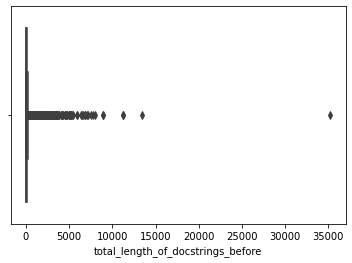

In [174]:
sns.boxplot(x='total_length_of_docstrings_before',
            data=methods_data);

По крайней мере больше половины методов в датасете не имеют докстрингов.

Теперь по функциям:

In [175]:
functions_data = source_code_data.loc[source_code_data['class_name'].isna()]

In [176]:
print(f'Среднее значение длины докстрингов равно {functions_data["total_length_of_docstrings_before"].mean()}.')
print(f'Медиана длины докстрингов равна {functions_data["total_length_of_docstrings_before"].median()}.')
print(f'Мода длины докстрингов равна {functions_data["total_length_of_docstrings_before"].mode()[0]} с частотой {functions_data["total_length_of_docstrings_before"].value_counts()[0]}.')
print(f'С.к.о длины докстрингов равно {functions_data["total_length_of_docstrings_before"].std()}.')
print(f'25-й персентиль длины докстрингов равен {functions_data["total_length_of_docstrings_before"].quantile(q=0.25)}.')
print(f'75-й персентиль длины докстрингов равен {functions_data["total_length_of_docstrings_before"].quantile(q=0.75)}.')
print(f'90-й персентиль длины докстрингов равен {functions_data["total_length_of_docstrings_before"].quantile(q=0.90)}.')
print(f'Минимум длины докстрингов равен {functions_data["total_length_of_docstrings_before"].min()}.')
print(f'Максимум длины докстрингов равен {functions_data["total_length_of_docstrings_before"].max()}.')

Среднее значение длины докстрингов равно 379.58357771260995.
Медиана длины докстрингов равна 41.0.
Мода длины докстрингов равна 0 с частотой 3466.
С.к.о длины докстрингов равно 1288.9399955825136.
25-й персентиль длины докстрингов равен 0.0.
75-й персентиль длины докстрингов равен 245.0.
90-й персентиль длины докстрингов равен 877.3999999999996.
Минимум длины докстрингов равен 0.
Максимум длины докстрингов равен 41889.


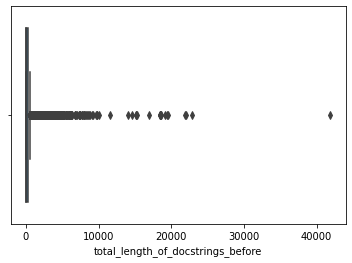

In [177]:
sns.boxplot(x='total_length_of_docstrings_before',
            data=functions_data);

Удалим выбросы:

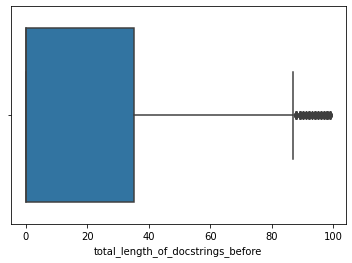

In [178]:
sns.boxplot(x='total_length_of_docstrings_before',
            data=functions_data.loc[functions_data['total_length_of_docstrings_before'] < 100]);

В функциях имеются докстринги, хотя в основном не очень большой длины.

Подсчитаем число раз, когда длина и число докстрингов не меняется при исправлениях:

In [179]:
print((source_code_data['total_length_of_docstrings_before'] == source_code_data['total_length_of_docstrings_after']).sum())
print((source_code_data['total_count_of_docstrings_before'] == source_code_data['total_count_of_docstrings_after']).sum())

21764
23244


У подавляющего большинства сниппетов длина и количество докстрингов не меняется.

Подсчитаем разницу между длиной докстрингов до и после исправления:

In [180]:
source_code_data['total_length_of_docstrings_difference'] = (source_code_data['total_length_of_docstrings_after'] - 
                                                             source_code_data['total_length_of_docstrings_before'])

Подсчитаем статистики распределения разности:

In [181]:
print(f'Среднее значение разницы длины докстрингов равно {source_code_data["total_length_of_docstrings_difference"].mean()}.')
print(f'Медиана разницы длины докстрингов равна {source_code_data["total_length_of_docstrings_difference"].median()}.')
print(f'Мода разницы длины докстрингов равна {source_code_data["total_length_of_docstrings_difference"].mode()[0]} с частотой {source_code_data["total_length_of_docstrings_difference"].value_counts()[0]}.')
print(f'С.к.о разницы длины докстрингов равно {source_code_data["total_length_of_docstrings_difference"].std()}.')
print(f'25-й персентиль разницы длины докстрингов равен {source_code_data["total_length_of_docstrings_difference"].quantile(q=0.25)}.')
print(f'75-й персентиль разницы длины докстрингов равен {source_code_data["total_length_of_docstrings_difference"].quantile(q=0.75)}.')
print(f'90-й персентиль разницы длины докстрингов равен {source_code_data["total_length_of_docstrings_difference"].quantile(q=0.95)}.')
print(f'Минимум разницы длины докстрингов равен {source_code_data["total_length_of_docstrings_difference"].min()}.')
print(f'Максимум разницы длины докстрингов равен {source_code_data["total_length_of_docstrings_difference"].max()}.')

Среднее значение разницы длины докстрингов равно 6.051634014704008.
Медиана разницы длины докстрингов равна 0.0.
Мода разницы длины докстрингов равна 0 с частотой 21764.
С.к.о разницы длины докстрингов равно 75.41855224212414.
25-й персентиль разницы длины докстрингов равен 0.0.
75-й персентиль разницы длины докстрингов равен 0.0.
90-й персентиль разницы длины докстрингов равен 2.0.
Минимум разницы длины докстрингов равен -2103.
Максимум разницы длины докстрингов равен 3276.


# Распределение названий функций

Посмотрим какие токены часто встречаются в названиях функций/методов. Если имя функции или метода составное на основе соглашений snake_case или camelCase, то это имя разбивается на отдельные токенв snake и case, либо camel и case.

In [129]:
def camelToSnake(name):
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', 
                  re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)).lower()


def removeEmptyItems(tokens_list):
    return [token for token in tokens_list if token]

In [130]:
source_code_data['function_name_tokens'] = source_code_data['function_name'].apply(lambda x: x.split('.')[-1]).apply(camelToSnake).apply(lambda x: x.split('_')).apply(removeEmptyItems)
function_name_tokens = Counter(source_code_data['function_name_tokens'].agg('sum'))

Число уникальных токенов:

In [131]:
len(function_name_tokens)

5609

Выделим наиболее часто встречающиеся токены в названиях методов/функций (больше 400)

In [132]:
frequently_occured_function_name_tokens = {k: v for k, v in function_name_tokens.items() if v > 400}

In [133]:
frequently_occured_function_name_tokens

{'from': 413,
 'init': 1920,
 'parse': 446,
 'update': 409,
 'set': 402,
 'create': 565,
 'get': 2105,
 'main': 454,
 'to': 510,
 'on': 407,
 'run': 590}

In [134]:
source_code_data['function_name'].apply(lambda x: '__init__' in x).sum(), methods_data['function_name'].apply(lambda x: '__init__' == x.split('.')[-1]).sum()

(1755, 1687)

Из 1755 сниппетов, имя которых содержит `__init__` 1687 сниппетов - это методы-конструкторы.

In [135]:
less_frequently_occured_function_name_tokens = {k: v for k, v in function_name_tokens.items() if (v > 200) and (v <= 400)}

In [136]:
less_frequently_occured_function_name_tokens

{'build': 208,
 'file': 355,
 'load': 338,
 'data': 321,
 'add': 359,
 'execute': 208,
 'is': 208,
 'process': 318,
 'call': 309,
 'check': 361,
 'handle': 213,
 'list': 255,
 'config': 211}

Наиболее часто встречающиеся токены - это init и get. Посмотрим в названиях каких функций они встречаются c учетом частоты

In [137]:
def getFuncNamesWithToken(data,
                          func_name_tokens_column,
                          func_name_column,
                          token):
    return data.loc[data[func_name_tokens_column].apply(lambda x: token in x), 
                    func_name_column].apply(lambda x: x.split('.')[-1]).value_counts()

df = getFuncNamesWithToken(source_code_data,
                           'function_name_tokens',
                           'function_name',
                           'get')
for index, count in zip(df.index, df):
    print(index, count)

get 71
get_dataset 25
render_GET 21
get_data 17
get_value 16
get_existing 13
get_file_hash 10
get_config 9
get_result 9
get_diff 8
get_hash 8
get_output 8
get_url 8
get_feature_meta 6
get_file 6
get_diff_input 6
get_services 6
get_vars 6
get_diff_output 6
get_loc 5
get_diff_input_output 5
get_tristate 5
_get 5
get_input_output 5
get_name 5
get_diff_tristate 5
get_input 5
get_posterior 4
get_jk 4
get_status 4
get_pem_entry 4
get_extras_require 4
get_event_iter_returns 4
get_option_link_args 4
get_source 4
GET 4
get_measurement 4
_GetStatus 4
_get_model 4
get_event 4
get_ticker_history 4
get_cpu_facts 4
get_iter_returns 4
get_completions 4
get_document_by_id 4
get_package 4
get_metadata 4
get_activations 3
get_config_value_and_origin 3
get_doc 3
on_GET 3
get_managed 3
_getDateTime 3
get_taskstatus 3
get_location 3
getUser 3
get_state 3
get_capabilities 3
get_categories 3
get_plugin_actions 3
get_id 3
get_project 3
_get_chunk_index_min_max 3
do_GET 3
get_properties 3
_get_full_key 3
__get

get_vm_format_secret 1
storage_get_data 1
get_nested_tasks 1
get_nic_inventory 1
get_playlist 1
get_table_file_path_relative 1
get_mapping 1
_get_options 1
get_full_lonlats 1
get_user 1
get_parameters 1
get_pool 1
on_get_chunk 1
get_fun 1
__get_version 1
get_env_patch 1
_get_page 1
get_task_specific_params 1
_get_series_episodes 1
get_nick_value 1
get_family 1
get_udld_global 1
get_filter_config 1
get_index_of_file_in_files 1
get_rectangle_cropping 1
get_added_date_string 1
_get_create_kwargs 1
get_actual_capacity 1
_get_payload 1
get_book_cover 1
_get_umf_family 1
_get_goes_sat_num 1
get_time_series 1
_get_slice_axis 1
get_context_from_db_entry_ipa 1
get_clouds 1
_get_value_and_line_offset 1
_get_listlike_indexer 1
get_implementations 1
get_magnet 1
get_all_group_policies 1
get_page 1
_get_orderby_clauses 1
_get_next_version 1
get_gl_entries 1
get_declaration 1
_get_keys_to_fetch 1
_get_torrent_hash 1
get_user_capabilities 1
_get_hg_root 1
get_pip 1
get_n_splits 1
_get_many 1
_get_win

_get_kw 1
get_new_columns 1
get_alert 1
_get_delegated_vars 1
get_billform_for 1
get_running_config 1
get_serial_number 1
get_allowed_vlans 1
get_user_managed_policy_data 1
get_src_requirement 1
get_optional_annotation 1
get_nics 1
get_resource_path 1
get_versions 1
get_expected_types 1
_get_calibration_params 1
get_api_client 1
get_new_session 1
get_address 1
_get_support_mask 1
get_attachment 1
_get_namedarg 1
get_or_create_public_ip_address 1
get_staged_files 1
get_top 1
get_imageplus_wrapper 1
_get_jar_args 1
get_extra_fields 1
_get_gcp_credentials 1
_get_first_line 1
GetAnalysisPluginsAndEventQueues 1
_get_dispatcher 1
get_info_dict 1
_get_bug_attr 1
_get_spotify_track_info 1
_getKeyForUrl 1
get_asset_path 1
_get_sitemap_body 1
get_topological_weights 1
get_line_at 1
get_ddf 1
get_distribution_id 1
getFilesIndex 1
getEnv 1
get_interfaces_ip 1
_get_processed_message_tokens_by_attribute 1
get_packages 1
get_default_values 1
_get_writer 1
get_builder 1
get_logical_line 1
get_dmi_fact

In [138]:
df = getFuncNamesWithToken(source_code_data,
                           'function_name_tokens',
                           'function_name',
                           'init')
for index, count in zip(df.index, df):
    print(index, count)

__init__ 1747
init 40
_init 16
_init_data_struct 4
get_init_guess 3
__singleton_init__ 3
do_class_init 3
_init_file 2
reset_init_only_vars 2
init_global_checks 2
init_dicts 2
init_subparser 2
_init_ccxt 2
_init_parameter_defaults 2
init_nuts 2
_init_libcrypto 2
init_events 2
init_ndarray 2
init_app 2
_init_i18n 2
init_plotscript 2
init_config 2
_init_modules 2
init_pluginsystem 2
_super_init 1
_init_glyph 1
_init_envvars 1
init_dict 1
init_model 1
_init_client 1
_init_packages_map 1
call_init 1
_manual_init 1
__init_streams 1
_init_samples_in_baskets 1
hydra_init 1
_init_lineparser 1
_init_casting_rules 1
_reduction_init_val 1
init_ida_rpc_client 1
_init_cache_for_non_constant_diag 1
init_profile_dir 1
_debug_init 1
doPostPluginsInit 1
init_pool_manager 1
init_artists 1
_restore_or_init_optimizer 1
get_init_detail 1
_init_cache 1
_post_init 1
_initAttributes 1
init_delta_command 1
sentry_init_error 1
init_on_load 1
init_to_median 1
_init_class_grads 1
TestInit 1
_init_js 1
init_ui 1
_i

Теперь наиболее часто встречающиеся пары токенов в названиях функций (биграммы).

In [139]:
import nltk

In [140]:
source_code_data['function_name_bigrams'] = source_code_data['function_name_tokens'].apply(nltk.bigrams)

In [141]:
function_name_bigrams = Counter(source_code_data['function_name_bigrams'].apply(list).agg('sum'))
frequently_occured_function_name_bigrams = {k: v for k, v in function_name_bigrams.items() if v > 20}

In [142]:
frequently_occured_function_name_bigrams

{('get', 'data'): 33,
 ('load', 'config'): 22,
 ('get', 'all'): 23,
 ('get', 'file'): 30,
 ('get', 'diff'): 30,
 ('render', 'get'): 21,
 ('get', 'dataset'): 26}

Таким образом, наиболее часто встречающиеся биграммы, это биграммы, содержащие токен get.

# Распределение сниппетов по репозиториям

In [143]:
source_code_data['repo_name'] = source_code_data['url'].apply(lambda x: '/'.join(x.split('/')[3:5]))

Покажем распределение сниппетов по репозиториям:

In [144]:
df = source_code_data['repo_name'].value_counts()

for index, count in zip(df.index, df):
    print(index, count) 

saltstack/salt 1801
ansible/ansible 1403
Tribler/tribler 714
pandas-dev/pandas 708
mars-project/mars 635
numba/numba 605
spyder-ide/spyder 546
Cog-Creators/Red-DiscordBot 440
pymedusa/Medusa 352
python/mypy 342
log2timeline/plaso 307
conda/conda 307
ray-project/ray 261
scikit-learn/scikit-learn 245
freqtrade/freqtrade 230
pytroll/satpy 228
iterative/dvc 221
modin-project/modin 220
sphinx-doc/sphinx 216
scipy/scipy 201
qutebrowser/qutebrowser 200
google/jax 184
PyTorchLightning/pytorch-lightning 162
Azure/azure-cli 159
pydata/xarray 146
mitmproxy/mitmproxy 140
MobSF/Mobile-Security-Framework-MobSF 135
CellProfiler/CellProfiler 135
RasaHQ/rasa 129
getnikola/nikola 129
DataBiosphere/toil 126
galaxyproject/galaxy 123
OctoPrint/OctoPrint 119
xonsh/xonsh 119
janeczku/calibre-web 116
riptideio/pymodbus 113
cornellius-gp/gpytorch 108
matrix-org/synapse 107
napari/napari 104
numpy/numpy 104
pantsbuild/pex 102
custom-components/alexa_media_player 98
Flexget/Flexget 97
leo-editor/leo-editor 96
ni

terraform-compliance/cli 3
django-oscar/django-oscar 3
OpenDroneMap/ODM 3
cocotb/cocotb 3
zim-desktop-wiki/zim-desktop-wiki 3
wandb/client 3
Toblerity/Fiona 3
open-mmlab/mmdetection 3
indico/indico 3
caronc/apprise 3
open-mmlab/mmsegmentation 3
colour-science/colour 3
pipxproject/pipx 3
googleapis/google-api-python-client 3
lk-geimfari/mimesis 3
jazzband/django-debug-toolbar 3
SoCo/SoCo 3
cobbler/cobbler 3
ets-labs/python-dependency-injector 2
scikit-learn-contrib/imbalanced-learn 2
jpype-project/jpype 2
dpkp/kafka-python 2
dj-stripe/dj-stripe 2
fecgov/openFEC 2
jupyterhub/kubespawner 2
trezor/trezor-firmware 2
twisted/towncrier 2
plamere/spotipy 2
facebookresearch/ParlAI 2
sshuttle/sshuttle 2
django/channels 2
ytorg/Yotter 2
jpadilla/pyjwt 2
celery/kombu 2
pndurette/gTTS 2
stamparm/maltrail 2
django-helpdesk/django-helpdesk 2
nolar/kopf 2
beeware/toga 2
jonathf/chaospy 2
facebook/prophet 2
relekang/python-semantic-release 2
alicevision/meshroom 2
jupyter/nbconvert 2
executablebooks/ju

Два самых популярных репозитория для сниппетов - это saltstack/salt и ansible/ansible

# Распределение сниппетов по инцидентам

Подсчитаем для каждого инцидента сколько к нему относится сниппетов.

In [145]:
df = source_code_data['url'].value_counts()

for index, count in zip(df.index, df):
    print(index, count)

https://github.com/numba/numba/issues/4944 230
https://github.com/Cog-Creators/Red-DiscordBot/issues/3238 206
https://github.com/pytroll/satpy/issues/123 169
https://github.com/saltstack/salt/issues/7687 146
https://github.com/freqtrade/freqtrade/issues/2948 125
https://github.com/qutebrowser/qutebrowser/issues/3634 123
https://github.com/MobSF/Mobile-Security-Framework-MobSF/issues/861 104
https://github.com/numba/numba/issues/25 103
https://github.com/pandas-dev/pandas/issues/1328 101
https://github.com/riptideio/pymodbus/issues/377 97
https://github.com/scikit-learn/scikit-learn/issues/3372 82
https://github.com/janeczku/calibre-web/issues/20 79
https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/29 78
https://github.com/edgedb/edgedb/issues/2002 61
https://github.com/google/pytype/issues/420 59
https://github.com/mars-project/mars/issues/814 57
https://github.com/conda/conda/issues/7040 56
https://github.com/iterative/dvc/issues/4144 54
https://github.com/Tribler/tr

https://github.com/sphinx-doc/sphinx/issues/904 8
https://github.com/qutebrowser/qutebrowser/issues/2930 8
https://github.com/RasaHQ/rasa/issues/3812 8
https://github.com/saltstack/salt/issues/28911 8
https://github.com/hubblestack/hubble/issues/493 8
https://github.com/MagicStack/asyncpg/issues/198 8
https://github.com/sqlalchemy/sqlalchemy/issues/5304 8
https://github.com/saltstack/salt/issues/50186 8
https://github.com/log2timeline/plaso/issues/498 8
https://github.com/saltstack/salt/issues/30980 8
https://github.com/mars-project/mars/issues/1448 8
https://github.com/nicolargo/glances/issues/1055 8
https://github.com/Tribler/tribler/issues/4578 8
https://github.com/deepset-ai/haystack/issues/278 8
https://github.com/saltstack/salt/issues/46932 8
https://github.com/ansible/ansible/issues/42932 8
https://github.com/mitmproxy/mitmproxy/issues/1061 8
https://github.com/frappe/erpnext/issues/6347 8
https://github.com/PyThaiNLP/pythainlp/issues/353 8
https://github.com/ansible/ansible/iss

https://github.com/fossasia/open-event-server/issues/4944 6
https://github.com/ansible/ansible/issues/29662 6
https://github.com/pallets/click/issues/942 6
https://github.com/numba/numba/issues/2169 6
https://github.com/RasaHQ/rasa/issues/6222 6
https://github.com/stan-dev/pystan/issues/201 6
https://github.com/iterative/dvc/issues/4985 6
https://github.com/ansible/ansible/issues/37051 6
https://github.com/postlund/pyatv/issues/2 6
https://github.com/jupyterhub/jupyterhub/issues/1626 6
https://github.com/sqlalchemy/sqlalchemy/issues/5520 6
https://github.com/pdfminer/pdfminer.six/issues/210 6
https://github.com/pandas-dev/pandas/issues/709 6
https://github.com/ray-project/ray/issues/13353 6
https://github.com/ansible/awx/issues/1546 6
https://github.com/spyder-ide/spyder/issues/11596 6
https://github.com/ansible/ansible/issues/23932 6
https://github.com/apple/coremltools/issues/554 6
https://github.com/cloud-custodian/cloud-custodian/issues/5724 6
https://github.com/pymedusa/Medusa/iss

https://github.com/MDAnalysis/mdanalysis/issues/1424 4
https://github.com/alteryx/featuretools/issues/496 4
https://github.com/Azure/azure-cli/issues/10179 4
https://github.com/microsoft/recommenders/issues/1132 4
https://github.com/ansible/ansible/issues/32396 4
https://github.com/mitmproxy/mitmproxy/issues/4382 4
https://github.com/beetbox/beets/issues/911 4
https://github.com/ansible/ansible/issues/15255 4
https://github.com/mesonbuild/meson/issues/1989 4
https://github.com/saltstack/salt/issues/44639 4
https://github.com/ebroecker/canmatrix/issues/499 4
https://github.com/numba/numba/issues/3355 4
https://github.com/holoviz/holoviews/issues/4378 4
https://github.com/certtools/intelmq/issues/1765 4
https://github.com/mars-project/mars/issues/1393 4
https://github.com/conan-io/conan/issues/6776 4
https://github.com/ansible/ansible/issues/36313 4
https://github.com/Tribler/tribler/issues/3200 4
https://github.com/mirumee/saleor/issues/5607 4
https://github.com/saltstack/salt/issues/36

https://github.com/conda/conda/issues/6860 3
https://github.com/apache/superset/issues/9545 3
https://github.com/scipy/scipy/issues/8271 3
https://github.com/rigetti/pyquil/issues/138 3
https://github.com/pipxproject/pipx/issues/231 3
https://github.com/jazzband/pip-tools/issues/851 3
https://github.com/wagtail/wagtail/issues/6540 3
https://github.com/pandas-dev/pandas/issues/25557 3
https://github.com/frappe/erpnext/issues/21669 3
https://github.com/leo-editor/leo-editor/issues/1415 3
https://github.com/pypa/pip/issues/4917 3
https://github.com/Qiskit/qiskit-terra/issues/2858 3
https://github.com/iterative/dvc/issues/4664 3
https://github.com/quodlibet/quodlibet/issues/2134 3
https://github.com/ytdl-org/youtube-dl/issues/10448 3
https://github.com/ansible/ansible/issues/30637 3
https://github.com/cloud-custodian/cloud-custodian/issues/4937 3
https://github.com/ansible/ansible/issues/60565 3
https://github.com/ansible/ansible/issues/18933 3
https://github.com/saltstack/salt/issues/2721

https://github.com/mitmproxy/mitmproxy/issues/2827 3
https://github.com/mne-tools/mne-python/issues/8824 3
https://github.com/sphinx-doc/sphinx/issues/8443 3
https://github.com/microsoft/recommenders/issues/919 3
https://github.com/leo-editor/leo-editor/issues/434 3
https://github.com/mars-project/mars/issues/1110 3
https://github.com/celery/celery/issues/5973 3
https://github.com/sphinx-doc/sphinx/issues/8100 3
https://github.com/lk-geimfari/mimesis/issues/619 3
https://github.com/python/mypy/issues/4649 3
https://github.com/psf/black/issues/1597 3
https://github.com/evennia/evennia/issues/1397 3
https://github.com/mitmproxy/mitmproxy/issues/1476 3
https://github.com/yt-project/yt/issues/1319 3
https://github.com/pandas-dev/pandas/issues/14362 3
https://github.com/OpenNMT/OpenNMT-tf/issues/414 3
https://github.com/pandas-dev/pandas/issues/18885 3
https://github.com/arviz-devs/arviz/issues/1166 3
https://github.com/PaddlePaddle/Paddle/issues/9019 3
https://github.com/pandas-dev/pandas/

https://github.com/mars-project/mars/issues/1960 3
https://github.com/galaxyproject/galaxy/issues/5031 3
https://github.com/mars-project/mars/issues/282 3
https://github.com/ParallelSSH/parallel-ssh/issues/121 3
https://github.com/borgbase/vorta/issues/473 3
https://github.com/yt-project/yt/issues/2778 3
https://github.com/mozilla/OpenWPM/issues/278 3
https://github.com/scrapy/scrapy/issues/4007 3
https://github.com/saltstack/salt/issues/49204 3
https://github.com/open-io/oio-sds/issues/1512 3
https://github.com/vispy/vispy/issues/528 3
https://github.com/spyder-ide/spyder/issues/9993 3
https://github.com/CellProfiler/CellProfiler/issues/422 3
https://github.com/ansible/ansible/issues/24453 3
https://github.com/Azure/azure-cli/issues/9486 3
https://github.com/pandas-dev/pandas/issues/27679 3
https://github.com/ultralytics/yolov5/issues/1507 3
https://github.com/sunpy/sunpy/issues/4699 3
https://github.com/python/mypy/issues/5195 3
https://github.com/saltstack/salt/issues/33578 3
https:

https://github.com/certtools/intelmq/issues/1035 2
https://github.com/RasaHQ/rasa/issues/4008 2
https://github.com/explosion/spaCy/issues/3093 2
https://github.com/koxudaxi/datamodel-code-generator/issues/225 2
https://github.com/xonsh/xonsh/issues/1259 2
https://github.com/xonsh/xonsh/issues/1754 2
https://github.com/wagtail/wagtail/issues/3967 2
https://github.com/sphinx-doc/sphinx/issues/6803 2
https://github.com/scipy/scipy/issues/8142 2
https://github.com/ansible/ansible/issues/36919 2
https://github.com/fossasia/open-event-server/issues/1905 2
https://github.com/PyTorchLightning/pytorch-lightning/issues/3549 2
https://github.com/pandas-dev/pandas/issues/24381 2
https://github.com/qutebrowser/qutebrowser/issues/3326 2
https://github.com/spyder-ide/spyder/issues/12034 2
https://github.com/saltstack/salt/issues/48599 2
https://github.com/automl/auto-sklearn/issues/409 2
https://github.com/leo-editor/leo-editor/issues/1098 2
https://github.com/rthalley/dnspython/issues/572 2
https://

https://github.com/aws/aws-cli/issues/309 2
https://github.com/ralphbean/bugwarrior/issues/694 2
https://github.com/ansible/ansible/issues/66504 2
https://github.com/pandas-dev/pandas/issues/4447 2
https://github.com/pydata/xarray/issues/3237 2
https://github.com/spyder-ide/spyder/issues/7513 2
https://github.com/samuelcolvin/pydantic/issues/541 2
https://github.com/docker/compose/issues/5527 2
https://github.com/saltstack/salt/issues/54741 2
https://github.com/CellProfiler/CellProfiler/issues/1148 2
https://github.com/aws/aws-sam-cli/issues/1392 2
https://github.com/Tribler/tribler/issues/3970 2
https://github.com/conda/conda/issues/3453 2
https://github.com/janeczku/calibre-web/issues/1387 2
https://github.com/ansible/ansible/issues/62331 2
https://github.com/mitmproxy/mitmproxy/issues/2816 2
https://github.com/Ericsson/codechecker/issues/1046 2
https://github.com/RasaHQ/rasa/issues/5162 2
https://github.com/pypa/pip/issues/9031 2
https://github.com/scipy/scipy/issues/2044 2
https://

https://github.com/ytdl-org/youtube-dl/issues/8350 2
https://github.com/leo-editor/leo-editor/issues/1450 2
https://github.com/spyder-ide/spyder/issues/10372 2
https://github.com/celery/celery/issues/4457 2
https://github.com/ansible/ansible/issues/31454 2
https://github.com/statsmodels/statsmodels/issues/1342 2
https://github.com/freedomofpress/securedrop/issues/5402 2
https://github.com/ray-project/ray/issues/2253 2
https://github.com/ray-project/ray/issues/10668 2
https://github.com/saltstack/salt/issues/25435 2
https://github.com/iterative/dvc/issues/3481 2
https://github.com/RUCAIBox/RecBole/issues/519 2
https://github.com/saltstack/salt/issues/46668 2
https://github.com/ansible/ansible/issues/30281 2
https://github.com/rochacbruno/dynaconf/issues/494 2
https://github.com/getnikola/nikola/issues/2137 2
https://github.com/saltstack/salt/issues/46341 2
https://github.com/SickChill/SickChill/issues/1269 2
https://github.com/Eloston/ungoogled-chromium/issues/717 2
https://github.com/n

https://github.com/ansible/ansible/issues/20641 2
https://github.com/zarr-developers/zarr-python/issues/439 2
https://github.com/MDAnalysis/mdanalysis/issues/1999 2
https://github.com/python/mypy/issues/2834 2
https://github.com/OpenMined/PySyft/issues/3496 2
https://github.com/spyder-ide/spyder/issues/13977 2
https://github.com/python-pillow/Pillow/issues/1462 2
https://github.com/Azure/azure-cli/issues/3649 2
https://github.com/conda/conda/issues/2599 2
https://github.com/galaxyproject/galaxy/issues/7108 2
https://github.com/Tribler/tribler/issues/4985 2
https://github.com/ansible/ansible/issues/49147 2
https://github.com/sphinx-doc/sphinx/issues/4279 2
https://github.com/ray-project/ray/issues/13199 2
https://github.com/samuelcolvin/pydantic/issues/696 2
https://github.com/ansible/ansible/issues/33804 2
https://github.com/saltstack/salt/issues/43995 2
https://github.com/mars-project/mars/issues/8 2
https://github.com/spyder-ide/spyder/issues/12410 2
https://github.com/pandas-dev/pan

https://github.com/ipython/ipython/issues/2637 2
https://github.com/giampaolo/psutil/issues/1486 2
https://github.com/pypa/virtualenv/issues/1635 2
https://github.com/gevent/gevent/issues/719 2
https://github.com/cornellius-gp/gpytorch/issues/620 2
https://github.com/statsmodels/statsmodels/issues/947 2
https://github.com/ipython/ipython/issues/2220 2
https://github.com/docker/compose/issues/6998 2
https://github.com/jupyterhub/jupyterhub/issues/1414 2
https://github.com/spack/spack/issues/2911 2
https://github.com/tensorflow/tfx/issues/57 2
https://github.com/angr/angr/issues/2448 2
https://github.com/crossbario/crossbar/issues/702 2
https://github.com/pymedusa/Medusa/issues/5463 2
https://github.com/kubeflow/pipelines/issues/4277 2
https://github.com/Zulko/moviepy/issues/1131 2
https://github.com/crytic/slither/issues/143 2
https://github.com/samuelcolvin/pydantic/issues/2320 2
https://github.com/pandas-dev/pandas/issues/17128 2
https://github.com/spyder-ide/spyder/issues/10439 2
htt

https://github.com/modin-project/modin/issues/864 1
https://github.com/freqtrade/freqtrade/issues/363 1
https://github.com/SciTools/cartopy/issues/1395 1
https://github.com/scikit-learn/scikit-learn/issues/7983 1
https://github.com/iterative/dvc/issues/5069 1
https://github.com/holoviz/holoviews/issues/1851 1
https://github.com/mopidy/mopidy/issues/911 1
https://github.com/spyder-ide/spyder/issues/14483 1
https://github.com/databricks/koalas/issues/1806 1
https://github.com/micahflee/onionshare/issues/1283 1
https://github.com/pymedusa/Medusa/issues/1759 1
https://github.com/bleachbit/bleachbit/issues/308 1
https://github.com/SALib/SALib/issues/99 1
https://github.com/zulip/zulip/issues/7132 1
https://github.com/locustio/locust/issues/1461 1
https://github.com/buildbot/buildbot/issues/5155 1
https://github.com/hyperspy/hyperspy/issues/1062 1
https://github.com/conda/conda/issues/7486 1
https://github.com/ewels/MultiQC/issues/1153 1
https://github.com/Unidata/MetPy/issues/619 1
https://

https://github.com/ewels/MultiQC/issues/392 1
https://github.com/pypa/pip/issues/5616 1
https://github.com/pyro-ppl/pyro/issues/2272 1
https://github.com/RaRe-Technologies/smart_open/issues/92 1
https://github.com/explosion/spaCy/issues/5620 1
https://github.com/OpenNMT/OpenNMT-tf/issues/152 1
https://github.com/nilearn/nilearn/issues/1725 1
https://github.com/Tribler/tribler/issues/5369 1
https://github.com/ultralytics/yolov5/issues/1760 1
https://github.com/pyqtgraph/pyqtgraph/issues/1094 1
https://github.com/mwaskom/seaborn/issues/2228 1
https://github.com/samuelcolvin/pydantic/issues/1943 1
https://github.com/mne-tools/mne-python/issues/8168 1
https://github.com/qutebrowser/qutebrowser/issues/3130 1
https://github.com/numpy/numpy/issues/6927 1
https://github.com/spyder-ide/spyder/issues/13422 1
https://github.com/napalm-automation/napalm/issues/810 1
https://github.com/ansible/ansible/issues/31056 1
https://github.com/lutris/lutris/issues/525 1
https://github.com/pymedusa/Medusa/is

https://github.com/scikit-learn/scikit-learn/issues/11332 1
https://github.com/statsmodels/statsmodels/issues/3349 1
https://github.com/ansible/ansible/issues/11988 1
https://github.com/lyft/cartography/issues/406 1
https://github.com/conan-io/conan/issues/2761 1
https://github.com/spyder-ide/spyder/issues/3942 1
https://github.com/Flexget/Flexget/issues/2249 1
https://github.com/saltstack/salt/issues/26171 1
https://github.com/pypa/pip/issues/5656 1
https://github.com/saltstack/salt/issues/45631 1
https://github.com/celery/celery/issues/5736 1
https://github.com/ansible/ansible/issues/21707 1
https://github.com/localstack/localstack/issues/455 1
https://github.com/spyder-ide/spyder/issues/13507 1
https://github.com/saltstack/salt/issues/26632 1
https://github.com/galaxyproject/galaxy/issues/8141 1
https://github.com/mapbox/rasterio/issues/240 1
https://github.com/python/mypy/issues/2794 1
https://github.com/dask/distributed/issues/3839 1
https://github.com/nicolargo/glances/issues/423

https://github.com/pymedusa/Medusa/issues/3036 1
https://github.com/WeblateOrg/weblate/issues/988 1
https://github.com/angr/angr/issues/1333 1
https://github.com/python/mypy/issues/4287 1
https://github.com/mopidy/mopidy/issues/1449 1
https://github.com/yt-project/yt/issues/1338 1
https://github.com/pandas-dev/pandas/issues/29718 1
https://github.com/python-pillow/Pillow/issues/2383 1
https://github.com/certtools/intelmq/issues/970 1
https://github.com/marshmallow-code/marshmallow/issues/298 1
https://github.com/google/jax/issues/4565 1
https://github.com/jrnl-org/jrnl/issues/392 1
https://github.com/saltstack/salt/issues/36865 1
https://github.com/scipy/scipy/issues/11082 1
https://github.com/saltstack/salt/issues/22327 1
https://github.com/holoviz/holoviews/issues/4328 1
https://github.com/theacodes/nox/issues/271 1
https://github.com/cloud-custodian/cloud-custodian/issues/4559 1
https://github.com/ansible/ansible/issues/14190 1
https://github.com/hyperspy/hyperspy/issues/924 1
https

https://github.com/qutebrowser/qutebrowser/issues/1270 1
https://github.com/ray-project/ray/issues/11309 1
https://github.com/prompt-toolkit/python-prompt-toolkit/issues/43 1
https://github.com/napari/napari/issues/1323 1
https://github.com/python-pillow/Pillow/issues/4087 1
https://github.com/saltstack/salt/issues/42374 1
https://github.com/SciTools/iris/issues/3921 1
https://github.com/theislab/scanpy/issues/1225 1
https://github.com/rotki/rotki/issues/1777 1
https://github.com/cython/cython/issues/3808 1
https://github.com/mwaskom/seaborn/issues/2451 1
https://github.com/pandas-dev/pandas/issues/31415 1
https://github.com/saltstack/salt/issues/43241 1
https://github.com/conda/conda/issues/6522 1
https://github.com/pwndbg/pwndbg/issues/858 1
https://github.com/Qiskit/qiskit-terra/issues/5754 1
https://github.com/ansible/ansible/issues/38232 1
https://github.com/saltstack/salt/issues/31897 1
https://github.com/ultralytics/yolov5/issues/1454 1
https://github.com/ebroecker/canmatrix/iss

https://github.com/ipython/ipython/issues/1428 1
https://github.com/conda/conda/issues/3531 1
https://github.com/conan-io/conan/issues/6484 1
https://github.com/apache/superset/issues/8676 1
https://github.com/frappe/frappe/issues/5448 1
https://github.com/ansible/ansible/issues/24542 1
https://github.com/modin-project/modin/issues/1386 1
https://github.com/docker/compose/issues/1826 1
https://github.com/saltstack/salt/issues/38839 1
https://github.com/PyTorchLightning/pytorch-lightning/issues/700 1
https://github.com/conan-io/conan/issues/3041 1
https://github.com/searx/searx/issues/1664 1
https://github.com/pdfminer/pdfminer.six/issues/66 1
https://github.com/eirannejad/pyRevit/issues/471 1
https://github.com/mopidy/mopidy/issues/1906 1
https://github.com/boto/boto3/issues/57 1
https://github.com/freqtrade/freqtrade/issues/3005 1
https://github.com/spyder-ide/spyder/issues/7403 1
https://github.com/saltstack/salt/issues/56205 1
https://github.com/saltstack/salt/issues/38091 1
https:/

https://github.com/wagtail/wagtail/issues/1397 1
https://github.com/espnet/espnet/issues/2483 1
https://github.com/ytdl-org/youtube-dl/issues/14665 1
https://github.com/galaxyproject/galaxy/issues/10824 1
https://github.com/saltstack/salt/issues/25192 1
https://github.com/ansible/ansible/issues/24672 1
https://github.com/statsmodels/statsmodels/issues/1864 1
https://github.com/aws/aws-cli/issues/1006 1
https://github.com/ansible/ansible/issues/39953 1
https://github.com/spyder-ide/spyder/issues/6727 1
https://github.com/dpkp/kafka-python/issues/1399 1
https://github.com/nltk/nltk/issues/681 1
https://github.com/pandas-dev/pandas/issues/33699 1
https://github.com/ralphbean/bugwarrior/issues/336 1
https://github.com/beetbox/beets/issues/570 1
https://github.com/ansible/ansible/issues/31269 1
https://github.com/psf/requests/issues/3481 1
https://github.com/scipy/scipy/issues/13501 1
https://github.com/flairNLP/flair/issues/1753 1
https://github.com/scikit-learn/scikit-learn/issues/17855 1

https://github.com/scipy/scipy/issues/2928 1
https://github.com/pandas-dev/pandas/issues/16164 1
https://github.com/certtools/intelmq/issues/1354 1
https://github.com/ansible/ansible/issues/21523 1
https://github.com/tmrowco/electricitymap-contrib/issues/1195 1
https://github.com/hubblestack/hubble/issues/248 1
https://github.com/numba/numba/issues/4201 1
https://github.com/Python-Markdown/markdown/issues/70 1
https://github.com/ansible/ansible/issues/38811 1
https://github.com/ansible/ansible/issues/22465 1
https://github.com/saltstack/salt/issues/25994 1
https://github.com/saltstack/salt/issues/27478 1
https://github.com/cloud-custodian/cloud-custodian/issues/6109 1
https://github.com/ibis-project/ibis/issues/900 1
https://github.com/OctoPrint/OctoPrint/issues/3676 1
https://github.com/django-cms/django-cms/issues/3938 1
https://github.com/yt-project/yt/issues/1337 1
https://github.com/freqtrade/freqtrade/issues/3363 1
https://github.com/nilearn/nilearn/issues/2303 1
https://github.c

https://github.com/frappe/frappe/issues/11097 1
https://github.com/CellProfiler/CellProfiler/issues/1684 1
https://github.com/spyder-ide/spyder/issues/6518 1
https://github.com/Tribler/tribler/issues/3863 1
https://github.com/pymedusa/Medusa/issues/4300 1
https://github.com/psf/requests/issues/338 1
https://github.com/Tribler/tribler/issues/4539 1
https://github.com/python/mypy/issues/1182 1
https://github.com/GafferHQ/gaffer/issues/1121 1
https://github.com/leo-editor/leo-editor/issues/1444 1
https://github.com/pypa/virtualenv/issues/490 1
https://github.com/bmoscon/cryptofeed/issues/282 1
https://github.com/certtools/intelmq/issues/1778 1
https://github.com/biolab/orange3/issues/5253 1
https://github.com/conda/conda/issues/2680 1
https://github.com/CellProfiler/CellProfiler/issues/3268 1
https://github.com/ansible/ansible/issues/70023 1
https://github.com/scipy/scipy/issues/12904 1
https://github.com/ray-project/ray/issues/1446 1
https://github.com/saltstack/salt/issues/47322 1
https

https://github.com/ansible/ansible/issues/43076 1
https://github.com/evennia/evennia/issues/1372 1
https://github.com/pypa/pipenv/issues/65 1
https://github.com/GenericMappingTools/pygmt/issues/409 1
https://github.com/spyder-ide/spyder/issues/10593 1
https://github.com/spyder-ide/spyder/issues/11790 1
https://github.com/ytdl-org/youtube-dl/issues/14789 1
https://github.com/mozilla/OpenWPM/issues/546 1
https://github.com/zalando/patroni/issues/488 1
https://github.com/spyder-ide/spyder/issues/14107 1
https://github.com/ray-project/ray/issues/13923 1
https://github.com/getnikola/nikola/issues/2681 1
https://github.com/docker/docker-py/issues/1980 1
https://github.com/indico/indico/issues/3209 1
https://github.com/python/mypy/issues/3574 1
https://github.com/pandas-dev/pandas/issues/15713 1
https://github.com/internetarchive/openlibrary/issues/1409 1
https://github.com/eth-brownie/brownie/issues/263 1
https://github.com/ray-project/ray/issues/11631 1
https://github.com/saltstack/salt/iss

https://github.com/mkdocs/mkdocs/issues/283 1
https://github.com/nicolargo/glances/issues/694 1
https://github.com/ansible/ansible/issues/13252 1
https://github.com/mitmproxy/mitmproxy/issues/3797 1
https://github.com/facebookresearch/hydra/issues/1227 1
https://github.com/saltstack/salt/issues/15171 1
https://github.com/python/mypy/issues/2848 1
https://github.com/Tribler/tribler/issues/3609 1
https://github.com/ansible/ansible/issues/36227 1
https://github.com/geopandas/geopandas/issues/1307 1
https://github.com/ansible/ansible/issues/17932 1
https://github.com/qutebrowser/qutebrowser/issues/2758 1
https://github.com/kivymd/KivyMD/issues/431 1
https://github.com/ansible/ansible/issues/57711 1
https://github.com/yt-project/yt/issues/2393 1
https://github.com/saltstack/salt/issues/46479 1
https://github.com/CellProfiler/CellProfiler/issues/1307 1
https://github.com/saulpw/visidata/issues/581 1
https://github.com/ranger/ranger/issues/2173 1
https://github.com/qutebrowser/qutebrowser/iss

https://github.com/Azure/azure-cli/issues/4188 1
https://github.com/Gallopsled/pwntools/issues/342 1
https://github.com/pandas-dev/pandas/issues/11854 1
https://github.com/ansible/ansible/issues/17895 1
https://github.com/mars-project/mars/issues/1463 1
https://github.com/cupy/cupy/issues/3601 1
https://github.com/pydicom/pydicom/issues/303 1
https://github.com/sanic-org/sanic/issues/1042 1
https://github.com/saltstack/salt/issues/32975 1
https://github.com/PyTorchLightning/pytorch-lightning/issues/2386 1
https://github.com/facebookresearch/ParlAI/issues/510 1
https://github.com/statsmodels/statsmodels/issues/236 1
https://github.com/Qiskit/qiskit-aqua/issues/1106 1
https://github.com/Pyomo/pyomo/issues/1642 1
https://github.com/pydicom/pydicom/issues/632 1
https://github.com/holoviz/panel/issues/1346 1
https://github.com/saltstack/salt/issues/57790 1
https://github.com/tensorflow/models/issues/2753 1
https://github.com/apache/superset/issues/8461 1
https://github.com/zulip/zulip/issue

https://github.com/modin-project/modin/issues/1647 1
https://github.com/modin-project/modin/issues/2134 1
https://github.com/tern-tools/tern/issues/874 1
https://github.com/DataBiosphere/toil/issues/1115 1
https://github.com/natlas/natlas/issues/426 1
https://github.com/opsdroid/opsdroid/issues/412 1
https://github.com/conan-io/conan/issues/2959 1
https://github.com/scikit-image/scikit-image/issues/5034 1
https://github.com/pandas-dev/pandas/issues/27365 1
https://github.com/allenai/allennlp/issues/4819 1
https://github.com/fepegar/torchio/issues/300 1
https://github.com/scrapy/scrapy/issues/2092 1
https://github.com/sympy/sympy/issues/3619 1
https://github.com/elastic/apm-agent-python/issues/188 1
https://github.com/zulip/zulip/issues/9207 1
https://github.com/saltstack/salt/issues/44165 1
https://github.com/IQTLabs/poseidon/issues/505 1
https://github.com/samuelcolvin/pydantic/issues/1190 1
https://github.com/localstack/localstack/issues/219 1
https://github.com/modin-project/modin/i

https://github.com/mlflow/mlflow/issues/1750 1
https://github.com/samuelcolvin/pydantic/issues/2111 1
https://github.com/spyder-ide/spyder/issues/8216 1
https://github.com/saltstack/salt/issues/42505 1
https://github.com/ansible/ansible/issues/35990 1
https://github.com/saltstack/salt/issues/34478 1
https://github.com/saltstack/salt/issues/48113 1
https://github.com/Parsl/parsl/issues/1657 1
https://github.com/mozilla/OpenWPM/issues/810 1
https://github.com/pandas-dev/pandas/issues/2549 1
https://github.com/zulip/zulip/issues/8289 1
https://github.com/nedbat/coveragepy/issues/907 1
https://github.com/crytic/slither/issues/173 1
https://github.com/mars-project/mars/issues/1404 1
https://github.com/pandas-dev/pandas/issues/31779 1
https://github.com/lutris/lutris/issues/3009 1
https://github.com/pvlib/pvlib-python/issues/865 1
https://github.com/Parsl/parsl/issues/1298 1
https://github.com/poliastro/poliastro/issues/1021 1
https://github.com/prompt-toolkit/python-prompt-toolkit/issues/15

В целом ни один из инцидентов не содержит в себе подавляющего числа сниппетов. Самый частый инцидент содержит 230 сниппетов. Всего сниппетов 23531.

# Распределение сниппетов по типу ошибок

In [146]:
df = source_code_data['traceback_type'].value_counts()

for index, count in zip(df.index, df):
    print(index, count)

AttributeError 3976
TypeError 3820
ValueError 2450
KeyError 1966
RuntimeError 1319
IndexError 1282
AssertionError 915
Exception 402
UnicodeDecodeError 381
OSError 352
ImportError 316
UnicodeEncodeError 304
FileNotFoundError 295
NameError 210
UnboundLocalError 208
IOError 173
ModuleNotFoundError 134
NotImplementedError 130
OperationalError 112
ZeroDivisionError 107
subprocess.CalledProcessError 92
PermissionError 85
RecursionError 83
nTypeError 74
json.decoder.JSONDecodeError 70
SyntaxError 67
OverflowError 65
CommandExecutionError 64
exceptions.AttributeError 57
MemoryError 55
dvc.exceptions.RemoteCacheRequiredError 54
botocore.exceptions.ClientError 52
sqlite3.OperationalError 51
LookupError 47
BrokenPipeError 46
nAttributeError 45
ConnectionError 45
ConnectionResetError 45
TimeoutError 45
tensorflow.python.framework.errors_impl.InvalidArgumentError 44
pydantic.error_wrappers.ValidationError 44
bleak.exc.BleakError 43
SystemError 38
WindowsError 37
EOFError 32
FileExistsError 31
pssh.

scipy.stats.distributions.FitSolverError 1
beets.mediafile.FileTypeError 1
conda._vendor.auxlib.exceptions.ValidationError 1
numpy.AxisError 1
YumBaseError 1
visidata.errors.ExpectedException 1
click.exceptions.ClickException 1
telegram.error 1
discord.errors.HTTPException 1
libcloud.common.google.ResourceNotFoundError 1
ruamel_yaml.representer.RepresenterError 1
UnsafeArchiveError 1
catch_config_error 1
InsufficientPermissionsException 1
BonjourError 1
JMESPathTypeError 1
qiskit._qiskiterror.QISKitError 1
QVMError 1
tornado.util.TimeoutError 1
fail_on_error 1
cPickle.PicklingError 1
electrum.util.UserFacingException 1
bioblend.ConnectionError 1
certbot.errors.MisconfigurationError 1
tvm._ffi.base.TVMError 1
botocore.errorfactory.TargetGroupNotFoundException 1
npsycopg2.ProgrammingError 1
FieldError 1
NonMatchingChecksumError 1
hydra.errors.HydraException 1
_curses.error 1
UnavailableException 1
galaxy.exceptions.ItemAccessibilityException 1
BadCredentialsException 1
builtins.ZeroDivis

наиболее часто встречающиеся ошибки:
    
- AttributeError 3976
- TypeError 3820
- ValueError 2450
- KeyError 1966
- RuntimeError 1319
- IndexError 1282
- AssertionError 915

Посмотрим на сообщения об ошибках:

In [147]:
def extractTracebackMessage(traceback_text):
    def processFoundPattern(pattern):
        if 'self' in pattern:
            return None
        if ':' in pattern:
            return pattern[1:]
        else:
            return pattern
    
    def processFoundContents(found_contents):
        for found_content in found_contents:
            found_pattern = processFoundPattern(found_content.group(0))
            if found_pattern:
                return found_pattern
            else:
                continue
        return None
                

    traceback_patterns = ['(\\n[.\w]+Error[.\w]*:.+)', '(\\n[.\w]+error[.\w]*:.+)',
                          '(\\n[.\w]*Exception[.\w]*:.+)', '(\\n[.\w]*exception[.\w]*:.+)',
                          '([\w.]+Error.+)', '([\w.]+error.+)']
    
    for traceback_pattern in traceback_patterns:
        found_pattern = processFoundContents(re.finditer(traceback_pattern,
                                                         traceback_text.strip()))
        if found_pattern:
            if ':' in found_pattern:
                return found_pattern.split(':')[1]
            elif 'Error' in found_pattern:
                return found_pattern.split('Error')[1]
            elif 'error' in found_pattern:
                return found_pattern.split('error')[1]

    return None

Для каждого сниппета подсчитаем сообщение об ошибке:

In [148]:
source_code_data['traceback_message'] = source_code_data['full_traceback'].apply(extractTracebackMessage)
df = source_code_data.loc[source_code_data['traceback_message'].notna()].copy()

In [149]:
import keyword
from nltk.tokenize import RegexpTokenizer

In [150]:
tokenizer = RegexpTokenizer(r'\w+')
df['traceback_tokens'] = df['traceback_message'].apply(lambda x: tokenizer.tokenize(x))
traceback_message_tokens = Counter(df['traceback_tokens'].agg('sum'))

Наиболее часто встречающиеся токены в сообщениях traceback:

In [151]:
traceback_message_tokens.most_common()[:100]

[('object', 5341),
 ('no', 4639),
 ('has', 4516),
 ('attribute', 4170),
 ('not', 3307),
 ('is', 2564),
 ('of', 2499),
 ('1', 2122),
 ('NoneType', 2084),
 ('0', 1876),
 ('to', 1557),
 ('in', 1512),
 ('a', 1426),
 ('2', 1414),
 ('index', 1349),
 ('for', 1290),
 ('be', 1274),
 ('out', 1273),
 ('the', 1234),
 ('or', 1224),
 ('argument', 1116),
 ('t', 1067),
 ('type', 1063),
 ('can', 1007),
 ('No', 985),
 ('with', 963),
 ('list', 947),
 ('range', 944),
 ('must', 933),
 ('Errno', 908),
 ('file', 798),
 ('name', 779),
 ('str', 748),
 ('codec', 711),
 ('position', 709),
 ('6', 690),
 ('module', 667),
 ('an', 653),
 ('got', 632),
 ('at', 592),
 ('such', 590),
 ('and', 575),
 ('gcc', 567),
 ('cannot', 561),
 ('string', 537),
 ('arch', 515),
 ('3', 495),
 ('int', 492),
 ('x86_64', 492),
 ('size', 487),
 ('u', 486),
 ('Cannot', 475),
 ('given', 463),
 ('error', 462),
 ('ascii', 459),
 ('value', 450),
 ('spack', 443),
 ('directory', 442),
 ('linux', 442),
 ('array', 441),
 ('centos6', 437),
 ('deco

Теперь наиболее часто встречающиеся биграмы:

In [152]:
df['traceback_bigrams'] = df['traceback_tokens'].apply(nltk.bigrams)

In [153]:
traceback_bigrams = Counter(df['traceback_bigrams'].apply(list).agg('sum'))

In [154]:
traceback_bigrams.most_common()[:100]

[(('has', 'no'), 4279),
 (('no', 'attribute'), 4112),
 (('object', 'has'), 3929),
 (('NoneType', 'object'), 1745),
 (('is', 'not'), 1239),
 (('out', 'of'), 1219),
 (('of', 'range'), 924),
 (('index', 'out'), 860),
 (('can', 't'), 859),
 (('must', 'be'), 782),
 (('codec', 'can'), 708),
 (('in', 'position'), 706),
 (('1', '0'), 620),
 (('object', 'is'), 522),
 (('6', '1'), 514),
 (('gcc', '6'), 513),
 (('No', 'such'), 473),
 (('list', 'index'), 467),
 (('ascii', 'codec'), 459),
 (('0', 'spack'), 437),
 (('arch', 'linux'), 437),
 (('linux', 'centos6'), 437),
 (('centos6', 'x86_64'), 437),
 (('Errno', '2'), 429),
 (('such', 'file'), 403),
 (('2', 'No'), 402),
 (('or', 'directory'), 401),
 (('of', 'type'), 398),
 (('file', 'or'), 398),
 (('t', 'decode'), 389),
 (('not', 'iterable'), 381),
 (('decode', 'byte'), 374),
 (('keyword', 'argument'), 326),
 (('t', 'encode'), 319),
 (('tuple', 'index'), 286),
 (('of', 'bounds'), 279),
 (('spack', 'arch'), 276),
 (('got', 'an'), 275),
 (('an', 'unexp

Теперь наиболее часто встречающиеся триграмы:

In [155]:
df['traceback_trigrams'] = df['traceback_tokens'].apply(nltk.trigrams)
traceback_trigrams = Counter(df['traceback_trigrams'].apply(list).agg('sum'))

In [156]:
traceback_trigrams.most_common()[:100]

[(('has', 'no', 'attribute'), 4112),
 (('object', 'has', 'no'), 3927),
 (('NoneType', 'object', 'has'), 1428),
 (('out', 'of', 'range'), 920),
 (('index', 'out', 'of'), 860),
 (('codec', 'can', 't'), 708),
 (('gcc', '6', '1'), 513),
 (('6', '1', '0'), 513),
 (('list', 'index', 'out'), 466),
 (('ascii', 'codec', 'can'), 459),
 (('object', 'is', 'not'), 450),
 (('1', '0', 'spack'), 437),
 (('arch', 'linux', 'centos6'), 437),
 (('linux', 'centos6', 'x86_64'), 437),
 (('No', 'such', 'file'), 403),
 (('Errno', '2', 'No'), 401),
 (('2', 'No', 'such'), 401),
 (('such', 'file', 'or'), 398),
 (('file', 'or', 'directory'), 398),
 (('can', 't', 'decode'), 389),
 (('is', 'not', 'iterable'), 381),
 (('t', 'decode', 'byte'), 374),
 (('can', 't', 'encode'), 319),
 (('NoneType', 'object', 'is'), 295),
 (('tuple', 'index', 'out'), 279),
 (('out', 'of', 'bounds'), 276),
 (('0', 'spack', 'arch'), 276),
 (('spack', 'arch', 'linux'), 276),
 (('got', 'an', 'unexpected'), 268),
 (('an', 'unexpected', 'keywor

Таким образом, наиболее часто встречающиеся ошибки: отсутствие атрибута, пустой объект, индекс вне диапазона.

# Распределение токенов в путях файлов

Посмотрим на распределение имен файлов:

In [157]:
source_code_data['actual_filename'] = source_code_data['filename'].apply(lambda x: x.split('/')[-1][:-3])

In [158]:
df = source_code_data['actual_filename'].value_counts()

for index, count in zip(df.index, df):
    print(index, count) 

__init__ 805
utils 317
base 289
core 279
client 172
audio 144
common 118
main 113
file 100
models 99
config 96
state 89
api 82
worker 80
series 75
frame 72
util 72
parfor 70
data 70
semanal 67
io 65
setup 63
dataset 62
indexing 59
web 58
plugin 56
plotting 55
checker 55
exceptions 54
groupby 53
compiler 53
types 50
unicode 50
app 49
parser 49
views 49
x509 47
custom 47
subtitles 46
_tqdm 46
loader 45
generic 45
commands 45
graph 45
codeeditor 44
zip_file 43
cli 42
manager 42
LibtorrentDownloadImpl 40
query_compiler 40
index 40
install 39
freqtradebot 38
server 38
help 37
internals 37
train 37
sync 36
editor 36
tiktok 36
converter 36
_utils 36
connection 36
__main__ 35
dispatcher 35
helpers 35
mysql 35
misc 35
interpreter 34
moments 34
templates 34
basic 33
schema 33
checkexpr 33
media_player 33
network 33
nodes 33
executor 32
payload 32
exchange 32
session 32
resample 32
ec2 32
tribler_window 31
fields 31
interface 31
vmware 31
nmcli 30
fileclient 30
dataframe 30
data_structures 30
con

tvdbv2_api 4
workspace 4
PixivUtil2 4
lock_store 4
imdb 4
_dotplot 4
transformers_pre_post_processors 4
random 4
signal1d 4
extending 4
nucaps 4
bag 4
_base 4
mapbase 4
yaml 4
vispy_base_layer 4
ast 4
jenkins_plugin 4
webserve 4
PixivHelper 4
tfr 4
periodic_kernel 4
bitbox02 4
optimize_reports 4
plot_prediction_latency 4
cookie 4
hg 4
analyze 4
ridge 4
rasanlu 4
index_tricks 4
runscansagentdb 4
rfe 4
relation 4
cfg_base 4
kraken 4
Seq 4
item 4
nxos_interface_ospf 4
isotonic 4
fixup 4
identify 4
nxos_vlan 4
kuus 4
natlas-agent 4
youtube 4
analyzer_types 4
ui 4
gml 4
btn 4
fast_gradient 4
TransferService 4
federation_client 4
runners 4
native 4
_compat 4
graph_binaries 4
qubit 4
tabular_nn_model 4
coordinates 4
ensemble 4
manifest 4
kubernetes 4
calculatemath 4
assemble 4
virtualbox 4
staged_files_only 4
main_update 4
main_config 4
autosave 4
runlib 4
fancysets 4
cups_ipp 4
parser_csv 4
config_converter 4
variational_strategy 4
sections 4
indexer 4
run_tunnel_helper 4
role_include 4
hand

downloads 3
syntaxhighlighters 3
tensorboard 3
synchronous_operations 3
exc 3
nc_olci 3
assigner 3
background_helper 3
abbr 3
commit 3
labeling_toolbox 3
nxos_rollback 3
naive_bayes 3
_faiss 3
azurearm 3
accounts 3
_download_async 3
interpolator 3
funcdesc 3
nzbstuff 3
_agglomerative 3
cpframe 3
na_ontap_gather_facts 3
glances_processes 3
intercept 3
dirstack 3
nxos_portchannel 3
scm 3
wallets 3
ipynb 3
activation_defence 3
_inv_quad_log_det 3
html5 3
ColorPlugValueWidget 3
sprite_list 3
nxos_bgp_neighbor_af 3
prometheus_exporter 3
extraction_frontend 3
integer 2
of_type 2
GuiPreferences 2
devicearray 2
workflows 2
rest_client 2
webapi 2
BlobRequester 2
install_scripts 2
objectholder 2
hmc_util 2
tuple_store_backend 2
robotstxt 2
edge 2
_asyncio_backend 2
GLScatterPlotItem 2
cf5dc11e79ad_drop_user_and_chart 2
encodingdb 2
disk 2
early_stopping 2
reductionfunction 2
deep_gp 2
dataclass_overlay 2
enum 2
watcher_conf 2
web_request 2
coo 2
linux_acl 2
property 2
dagrun 2
coresight_target 2

ir_print 2
win_useradd 2
forest2-simple-prog 2
_fetch_util 2
ruby 2
ltisys 2
0053_unitdata 2
req_set 2
trait_types 2
leoBeautify 2
warnings 2
CuraEngineBackend 2
var 2
inv 2
mac_system 2
_profile 2
sql_listing 2
GenericList 2
plantcv-pipeline 2
default_learner 2
MY_WM 2
expression 2
merge_pyi 2
decoders 2
has_props 2
fileJobStore 2
zeros 2
thrift_helper 2
persistence_diagrams 2
namesubscriber 2
quiver 2
netcli 2
semantic_segmentation_raster_store 2
mdns 2
virt_query 2
rnn_decoder 2
operator 2
ipset 2
thread 2
callconv 2
lint 2
git_pillar 2
lineinfile 2
winreg 2
morris 2
load_pytd 2
PrecisionFilter 2
wiring 2
modbus_payload 2
cut 2
package_cache_layout 2
twenty_newsgroups 2
init_model 2
yukicoder 2
vcs 2
stock_entry 2
classifier 2
authorization 2
global_checks 2
_lagrangian 2
world_menus 2
todo 2
maptype 2
openstack_inventory 2
homepage 2
json_serializer 2
viewgen 2
manpage 2
custom_message 2
netbox 2
rulelib 2
viewer_2d 2
marathon 2
counts 2
apk 2
amsr2_l1b 2
dagascii 2
config_installe

injection_shell 1
sequence_decoders 1
baseapp 1
pdist 1
importer_node 1
golang 1
onion 1
cartesian_coordinates 1
sasreader 1
octobot 1
stanza 1
solaris_shadow 1
pep425tags 1
rmq_connection 1
mwe 1
redditor 1
twilio 1
presence 1
grid_engine 1
geventlet 1
bigpanda 1
ssh_service 1
integrity 1
azurefs 1
waveformseekbar 1
morethantv 1
toml2py 1
layer_norm 1
mdf 1
postgres_local_cache 1
text_events 1
ransac 1
fx2 1
timeseries_feature 1
sar 1
custom_datablock 1
dock 1
stateobject 1
nvvm 1
plot_covhist 1
estimator 1
xen 1
vca 1
matrix_federation_agent 1
dbt 1
pzmap 1
vocab 1
top 1
hypothesispython 1
conv2d_winograd 1
lm_utils 1
particle_trajectories 1
room_list 1
esmtlnovel 1
elasticapm 1
cftimeindex 1
deepreload 1
initialization 1
attacked_text 1
prototypes 1
statevector_simulator 1
ddp_spawn_backend 1
mongo_future_return 1
FusedNode 1
matmul_lazy_tensor 1
_pydev_jy_imports_tipper 1
idxstats 1
rotate 1
ios_static_route 1
_permission 1
variable_access 1
voipbl 1
msg_dispatcher 1
tower_job_laun

tvepisode 1
extension 1
gcmc 1
cray 1
chunkmeta 1
0024_resolve_auto_format 1
parsed_tf_node 1
request_handler 1
hb_bohb 1
minstall 1
MonitorCenter 1
import_export_content 1
nxos_acl 1
regexhandler 1
zabbix_template 1
light 1
S3 1
plugins_manager 1
general_ledger 1
numpy_support 1
rearrange 1
mssqlexec 1
sysrc 1
kinesis_listener 1
qaoa_ansatz 1
sam_function_provider 1
frmtlnovel 1
suggestion 1
meas_info 1
freemobile 1
0006_subscriptions 1
smac_tuner 1
worker_set 1
view_layers 1
idmtlnovel 1
cosmosdbsql 1
blob_announcer 1
k_means_ 1
grafana 1
0013_fix_repo_scope 1
clinic 1
issuesubmitter 1
dag_visualization 1
_component_bridge 1
paga 1
orthogonal 1
explained_variance 1
panes 1
indexed_component_slice 1
dbc 1
mrulistex 1
rlutil 1
general_callbacks 1
_get 1
s3_lifecycle 1
gftracker 1
ax 1
socketcan 1
nevergrad 1
entity_linker 1
inet 1
to_csv 1
ec2_vpc_nacl 1
nagios_return 1
gen 1
version_checker 1
scalarstring 1
qt_gui 1
voting_classifier 1
ipy_completer 1
gateway_client 1
type_check 1
has

SunImagePlugin 1
get_email 1
random_data 1
firehose_api 1
event_signature 1
tensorflow_model_dataset 1
ec2_vpc_vgw_facts 1
opennebula 1
mean_squared_error 1
tf_policy 1
hotkeysettings 1
prediction_head 1
conll 1
fastparse2 1
localdb 1
squeues 1
py3tool 1
tensordot 1
927ed575acbd_add_currencies 1
wallet_utils 1
platform_utils 1
wdtv 1
elasticache_subnet_group 1
kernelmanager 1
stripe_objects 1
aws_ssm_parameter_store 1
dpkg_lowpkg 1
payment_entry 1
staticfiles 1
toilStatus 1
java_keystore 1
nxos_config 1
plot_basic_hist 1
MOL2 1
blacklisting 1
NO 1
change_log 1
extractor 1
cs_sshkeypair 1
noise 1
basevalidators 1
minion_process 1
optimizers_v2 1
_purefa_facts 1
type_coercion 1
LV 1
tower_project 1
member 1
loaddata 1
pushover 1
groupby_wrapper 1
rabbitmq_parameter 1
consoleaddons 1
pageadmin 1
localsyslog 1
certs 1
iosxr_command 1
bag_feature 1
contextfactory 1
athena 1
chooser 1
resnet-train-pipeline 1
expresso 1
session_id 1
pynio_ 1
binary_framer 1
channels_subscription_endpoint 1
pi

_coupling 1
menu 1
bk 1
danishbits 1
input_events 1
custom_types 1
AzureStorage 1
dellos10_config 1
_version 1
ps 1
bed_to_gff_converter 1
Resource 1
loc 1
batch_beam_search 1
mosaicplot 1
qt_modal 1
crop_or_pad 1
synchronous_server 1
ranker 1
nbbase 1
linux_command 1
urlmarks 1
staking 1
nmf 1
osutil 1
addon 1
pailgun_service 1
parquet_reader 1
directory_operations 1
_vectorized 1
stringregexhandler 1
ios_interface 1
show_examples 1
evtable 1
parse_yul 1
stack_utils 1
prefixed_command_runner 1
tickets 1
pygments_highlighter 1
forest 1
math_directive 1
reload 1
accelerator 1
module_completion 1
lbfgsb 1
AppriseLocale 1
aggregates 1
average 1
panda 1
simulator 1
scanning 1
analytics 1
neg_binomial 1
circuitpython 1
random_generator 1
any 1
matrixfederationclient 1
no_config_file_override 1
songlist 1
sas_xport 1
healthcheck 1
run_training 1
swarm 1
localfs 1
hdf5 1
fixed_width 1
machinetransorg 1
leoAst 1
glances_cloud 1
hounddawgs 1
edittags 1
inputhook 1
iam_policy 1
LegendItem 1
fetc

Наиболее популярные имена файлов: __init__, utils, base и core.

Посмотрим в каких репозиториях эти имена файлов содержатся

In [159]:
df = source_code_data.loc[source_code_data['actual_filename'].apply(lambda x: ('__init__ ' == x) or ('utils' == x) or ('core' == x)), 'repo_name'].value_counts()
for index, count in zip(df.index, df):
    print(index, count) 

mars-project/mars 148
pypa/pipenv 37
numpy/numpy 24
saltstack/salt 21
MobSF/Mobile-Security-Framework-MobSF 19
jrnl-org/jrnl 18
Cog-Creators/Red-DiscordBot 17
secdev/scapy 15
facebookresearch/hydra 11
astropy/astroquery 10
cloud-custodian/cloud-custodian 10
OctoPrint/OctoPrint 10
activeloopai/Hub 8
opsdroid/opsdroid 8
pymedusa/Medusa 8
mne-tools/mne-python 8
HypothesisWorks/hypothesis 7
getnikola/nikola 7
spyder-ide/spyder 6
ultralytics/yolov5 6
ansible/ansible 6
pallets/click 6
RasaHQ/rasa 6
pytorch/fairseq 5
samuelcolvin/pydantic 5
RaRe-Technologies/gensim 5
docker/compose 5
hbldh/bleak 5
pimutils/khal 5
lektor/lektor 4
pydata/xarray 4
tiangolo/fastapi 4
doccano/doccano 4
pytroll/satpy 4
rlworkgroup/garage 4
Tencent/bk-sops 3
raiden-network/raiden 3
wagtail/wagtail 3
deepset-ai/haystack 3
ytdl-org/youtube-dl 3
SoCo/SoCo 3
lbryio/lbry-sdk 3
ansible-community/molecule 3
pykeen/pykeen 3
ansible-community/ansible-lint 3
zarr-developers/zarr-python 2
pallets/jinja 2
pdfminer/pdfminer.six 

Теперь посмотрим на распределение токенов в полных путях файлов (токены получаются разбиением названия папки по символу /):

In [160]:
source_code_data['folder_name_tokens'] = source_code_data['filename'].apply(lambda x: x.split('/')[:-1])
folder_name_tokens = Counter(source_code_data['folder_name_tokens'].apply(list).agg('sum'))

In [161]:
most_frequently_occured_folder_name_tokens = folder_name_tokens.most_common()[:8]

Наиболее популярные названия в полных путях файлов

In [162]:
most_frequently_occured_folder_name_tokens

[('lib', 1928),
 ('salt', 1788),
 ('modules', 1704),
 ('ansible', 1379),
 ('src', 1362),
 ('core', 1309),
 ('plugins', 903),
 ('pandas', 821)]

Среднепопулярные токены в полных путях к файлам:

In [163]:
frequently_occured_folder_name_tokens = folder_name_tokens.most_common()[8:30]

In [164]:
frequently_occured_folder_name_tokens

[('utils', 649),
 ('mars', 635),
 ('numba', 603),
 ('widgets', 512),
 ('cloud', 496),
 ('spyder', 487),
 ('redbot', 438),
 ('cli', 416),
 ('Tribler', 375),
 ('python', 359),
 ('mypy', 342),
 ('cogs', 325),
 ('Core', 301),
 ('plaso', 290),
 ('dataframe', 286),
 ('conda', 284),
 ('models', 267),
 ('network', 264),
 ('audio', 261),
 ('states', 250),
 ('backends', 246),
 ('freqtrade', 229)]

# Распределение токенов в исходном тексте сниппетов, не являющихся ключевыми словами

Исследуем распределение токенов в исходном тексте сниппетов, не являющихся ключевыми словами:

Функция извлечения токенов и субтокенов (учет snake_case и camelCase форматирования)

In [165]:
def extractNonKeywordTokens(snippet):
    tokenizer = RegexpTokenizer(r'\w+')
    non_keyword_tokens = [token for token in tokenizer.tokenize(snippet) if not keyword.iskeyword(token)]
    non_keyword_subtokens = []
    for token in non_keyword_tokens:
        non_keyword_subtokens.extend(subtoken for subtoken in camelToSnake(token).lower().split('_') if subtoken)
    frequent_non_keyword_tokens = Counter(non_keyword_tokens).most_common()
    frequent_non_keyword_subtokens = Counter(non_keyword_subtokens).most_common()
    
    return {'tokens': [token for token, _ in frequent_non_keyword_tokens], 
            'subtokens' : [subtoken for subtoken, _ in frequent_non_keyword_subtokens]}

Подсчитаем токены и подтокены для каждого сниппета до и после исправления.

In [166]:
nonkeyword_tokens_n_subtokens = source_code_data['before_merge_without_docstrings'].apply(extractNonKeywordTokens)
source_code_data['nonkeyword_tokens_before'] = nonkeyword_tokens_n_subtokens.apply(lambda x: x['tokens'])
source_code_data['nonkeyword_subtokens_before'] = nonkeyword_tokens_n_subtokens.apply(lambda x: x['subtokens'])

In [167]:
nonkeyword_tokens_n_subtokens = source_code_data['after_merge_without_docstrings'].apply(extractNonKeywordTokens)
source_code_data['nonkeyword_tokens_after'] = nonkeyword_tokens_n_subtokens.apply(lambda x: x['tokens'])
source_code_data['nonkeyword_subtokens_after'] = nonkeyword_tokens_n_subtokens.apply(lambda x: x['subtokens'])

In [168]:
nonkeyword_tokens = Counter(source_code_data['nonkeyword_tokens_before'].agg('sum'))
nonkeyword_subtokens = Counter(source_code_data['nonkeyword_subtokens_before'].agg('sum'))

Наиболее часто встречающиеся в тексте токены:

In [169]:
nonkeyword_tokens.most_common()[:400]

[('self', 14277),
 ('0', 10081),
 ('1', 8366),
 ('name', 5011),
 ('s', 4971),
 ('format', 4578),
 ('len', 4435),
 ('get', 4198),
 ('isinstance', 4066),
 ('str', 4005),
 ('to', 3864),
 ('append', 3840),
 ('path', 3302),
 ('2', 3176),
 ('data', 2985),
 ('list', 2851),
 ('os', 2828),
 ('join', 2798),
 ('a', 2697),
 ('type', 2463),
 ('int', 2449),
 ('the', 2325),
 ('args', 2317),
 ('n', 2251),
 ('f', 2194),
 ('value', 2169),
 ('info', 2168),
 ('be', 2155),
 ('key', 2146),
 ('dict', 2128),
 ('ValueError', 2124),
 ('debug', 2110),
 ('np', 2098),
 ('_', 2070),
 ('kwargs', 2063),
 ('error', 2027),
 ('r', 2006),
 ('set', 1932),
 ('config', 1901),
 ('__init__', 1887),
 ('log', 1876),
 ('of', 1840),
 ('result', 1832),
 ('items', 1814),
 ('i', 1786),
 ('e', 1763),
 ('logger', 1736),
 ('update', 1727),
 ('x', 1712),
 ('split', 1674),
 ('Exception', 1650),
 ('index', 1540),
 ('id', 1539),
 ('3', 1462),
 ('d', 1462),
 ('msg', 1459),
 ('file', 1447),
 ('bool', 1419),
 ('copy', 1372),
 ('shape', 1333),

Наиболее часто встречающиеся в тексте подтокены:

In [170]:
nonkeyword_subtokens.most_common()[:400]

[('self', 14319),
 ('get', 10353),
 ('0', 10096),
 ('1', 8399),
 ('error', 8254),
 ('name', 7726),
 ('to', 6702),
 ('type', 5585),
 ('s', 5331),
 ('format', 5185),
 ('data', 5012),
 ('value', 4881),
 ('list', 4672),
 ('path', 4523),
 ('str', 4503),
 ('len', 4498),
 ('set', 4432),
 ('isinstance', 4071),
 ('append', 3939),
 ('is', 3729),
 ('dict', 3725),
 ('id', 3687),
 ('info', 3646),
 ('key', 3643),
 ('file', 3561),
 ('2', 3232),
 ('os', 3053),
 ('a', 2989),
 ('add', 2989),
 ('n', 2965),
 ('join', 2912),
 ('args', 2900),
 ('update', 2873),
 ('exception', 2842),
 ('log', 2748),
 ('config', 2748),
 ('the', 2702),
 ('int', 2658),
 ('index', 2587),
 ('init', 2584),
 ('check', 2542),
 ('f', 2529),
 ('debug', 2423),
 ('result', 2353),
 ('logger', 2321),
 ('kwargs', 2320),
 ('of', 2315),
 ('x', 2303),
 ('from', 2274),
 ('new', 2258),
 ('be', 2239),
 ('r', 2224),
 ('default', 2222),
 ('all', 2198),
 ('i', 2175),
 ('np', 2130),
 ('on', 2122),
 ('no', 2079),
 ('text', 2076),
 ('items', 1969),
 (

Теперь для биграммов:

In [171]:
source_code_data['nonkeyword_tokens_bigrams_before'] = source_code_data['nonkeyword_tokens_before'].apply(nltk.bigrams)
source_code_data['nonkeyword_subtokens_bigrams_before'] = source_code_data['nonkeyword_subtokens_before'].apply(nltk.bigrams)

In [172]:
nonkeyword_tokens_bigrams = Counter(source_code_data['nonkeyword_tokens_bigrams_before'].apply(list).agg('sum'))
nonkeyword_subtokens_bigrams = Counter(source_code_data['nonkeyword_subtokens_bigrams_before'].apply(list).agg('sum'))

In [173]:
nonkeyword_tokens_bigrams.most_common()[:100]

[(('os', 'path'), 941),
 (('0', '1'), 620),
 (('0', 'format'), 589),
 (('must', 'be'), 572),
 (('utf', '8'), 527),
 (('salt', 'utils'), 454),
 (('args', 'kwargs'), 395),
 (('path', 'join'), 395),
 (('logger', 'info'), 356),
 (('logger', 'debug'), 343),
 (('len', '1'), 325),
 (('1', '0'), 322),
 (('log', 'debug'), 320),
 (('fail_json', 'msg'), 307),
 (('len', '0'), 306),
 (('Failed', 'to'), 305),
 (('does', 'exist'), 275),
 (('traceback', 'format_exc'), 271),
 (('warnings', 'warn'), 261),
 (('1', 'format'), 227),
 (('1', '2'), 209),
 (('time', 'sleep'), 204),
 (('k', 'v'), 201),
 (('Unable', 'to'), 201),
 (('self', '0'), 200),
 (('has', 'been'), 200),
 (('json', 'dumps'), 198),
 (('isinstance', 'dict'), 198),
 (('x', 'y'), 197),
 (('isinstance', 'list'), 188),
 (('self', 'name'), 185),
 (('commands', 'Context'), 177),
 (('will', 'be'), 173),
 (('isinstance', 'str'), 172),
 (('self', 'data'), 163),
 (('key', 'value'), 157),
 (('self', '__init__'), 155),
 (('__opts__', 'test'), 155),
 (('

In [174]:
nonkeyword_subtokens_bigrams.most_common()[:100]

[(('value', 'error'), 882),
 (('0', '1'), 626),
 (('must', 'be'), 594),
 (('utf', '8'), 584),
 (('0', 'format'), 568),
 (('os', 'path'), 550),
 (('logger', 'debug'), 483),
 (('args', 'kwargs'), 375),
 (('logger', 'info'), 371),
 (('log', 'debug'), 368),
 (('not', 'implemented'), 333),
 (('len', '1'), 328),
 (('1', '0'), 326),
 (('len', '0'), 311),
 (('x', 'y'), 293),
 (('string', 'types'), 293),
 (('failed', 'to'), 286),
 (('does', 'exist'), 277),
 (('self', 'name'), 264),
 (('warnings', 'warn'), 259),
 (('salt', 'utils'), 248),
 (('number', 'of'), 247),
 (('type', 'error'), 240),
 (('not', 'found'), 233),
 (('1', '2'), 226),
 (('argument', 'spec'), 224),
 (('1', 'format'), 218),
 (('runtime', 'error'), 211),
 (('data', 'frame'), 207),
 (('self', 'get'), 205),
 (('self', 'data'), 201),
 (('k', 'v'), 200),
 (('path', 'join'), 198),
 (('key', 'value'), 195),
 (('unable', 'to'), 194),
 (('has', 'been'), 191),
 (('key', 'error'), 189),
 (('time', 'sleep'), 189),
 (('logger', 'warning'), 18

# Распределение токенов в докстрингах

In [175]:
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package wordnet to /home/kks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
def extractDocstringTokens(docstrings):
    tokenizer = RegexpTokenizer(r'\w+')
    wordnet_lemmatizer = WordNetLemmatizer()
    
    tokens = []
    subtokens = []
    for docstring in docstrings:
        tokens += [wordnet_lemmatizer.lemmatize(token.lower()) for token in tokenizer.tokenize(docstring) if token.lower() not in en_stop]
        for token in tokens:
            subtokens.extend(wordnet_lemmatizer.lemmatize(subtoken) for subtoken in camelToSnake(token).lower().split('_') if subtoken.lower() and (subtoken not in en_stop))
    
    return {'tokens': tokens, 
            'subtokens' : subtokens}

In [177]:
docstring_tokens_n_subtokens = source_code_data['before_merge_docstrings'].apply(extractDocstringTokens)
source_code_data['docstrings_tokens_before'] = docstring_tokens_n_subtokens.apply(lambda x: x['tokens'])
source_code_data['docstrings_subtokens_before'] = docstring_tokens_n_subtokens.apply(lambda x: x['subtokens'])

In [178]:
docstring_tokens_n_subtokens = source_code_data['after_merge_docstrings'].apply(extractDocstringTokens)
source_code_data['docstrings_tokens_after'] = docstring_tokens_n_subtokens.apply(lambda x: x['tokens'])
source_code_data['docstrings_subtokens_after'] = docstring_tokens_n_subtokens.apply(lambda x: x['subtokens'])

In [179]:
docstring_tokens = Counter(source_code_data['docstrings_tokens_before'].agg('sum'))
docstring_subtokens = Counter(source_code_data['docstrings_subtokens_before'].agg('sum'))

Наиболее часто встречающиеся в тексте токены:

In [180]:
docstring_tokens.most_common()[:400]

[('return', 6323),
 ('0', 5394),
 ('1', 4974),
 ('param', 4499),
 ('default', 4440),
 ('file', 4365),
 ('value', 4149),
 ('list', 3695),
 ('name', 3530),
 ('true', 3423),
 ('data', 3347),
 ('none', 3153),
 ('optional', 3071),
 ('parameter', 2776),
 ('str', 2745),
 ('2', 2700),
 ('function', 2660),
 ('type', 2628),
 ('array', 2607),
 ('object', 2578),
 ('set', 2571),
 ('used', 2566),
 ('x', 2305),
 ('example', 2285),
 ('string', 2207),
 ('use', 2207),
 ('salt', 2054),
 ('false', 2027),
 ('number', 2017),
 ('path', 1966),
 ('code', 1865),
 ('key', 1862),
 ('argument', 1831),
 ('int', 1824),
 ('3', 1789),
 ('bool', 1770),
 ('given', 1766),
 ('args', 1678),
 ('method', 1557),
 ('user', 1538),
 ('block', 1532),
 ('class', 1531),
 ('dict', 1502),
 ('model', 1411),
 ('one', 1349),
 ('using', 1327),
 ('run', 1297),
 ('specified', 1256),
 ('index', 1215),
 ('instance', 1207),
 ('float', 1195),
 ('command', 1179),
 ('input', 1171),
 ('note', 1170),
 ('get', 1121),
 ('state', 1116),
 ('new', 1113

Наиболее часто встречающиеся в тексте подтокены:

In [181]:
docstring_subtokens.most_common()[:400]

[('return', 7372),
 ('0', 5561),
 ('param', 5325),
 ('file', 5304),
 ('1', 5165),
 ('default', 4797),
 ('value', 4641),
 ('name', 4607),
 ('list', 4382),
 ('data', 4018),
 ('true', 3698),
 ('none', 3369),
 ('type', 3248),
 ('optional', 3235),
 ('array', 3039),
 ('parameter', 3032),
 ('object', 3013),
 ('function', 2999),
 ('2', 2903),
 ('used', 2876),
 ('set', 2873),
 ('str', 2827),
 ('x', 2663),
 ('use', 2635),
 ('path', 2543),
 ('key', 2503),
 ('example', 2438),
 ('string', 2343),
 ('number', 2313),
 ('salt', 2208),
 ('false', 2174),
 ('n', 2107),
 ('channel', 2024),
 ('given', 2021),
 ('argument', 2008),
 ('code', 2001),
 ('int', 1911),
 ('args', 1910),
 ('class', 1861),
 ('3', 1858),
 ('user', 1846),
 ('bool', 1836),
 ('method', 1820),
 ('model', 1773),
 ('id', 1725),
 ('dict', 1673),
 ('get', 1673),
 ('block', 1609),
 ('run', 1583),
 ('new', 1543),
 ('one', 1498),
 ('state', 1485),
 ('index', 1462),
 ('instance', 1384),
 ('using', 1377),
 ('time', 1337),
 ('input', 1332),
 ('sampl

Теперь для биграммов:

In [182]:
source_code_data['docstrings_tokens_bigrams_before'] = source_code_data['docstrings_tokens_before'].apply(nltk.bigrams)
source_code_data['docstrings_subtokens_bigrams_before'] = source_code_data['docstrings_subtokens_before'].apply(nltk.bigrams)

In [183]:
docstring_tokens_bigrams = Counter(source_code_data['docstrings_tokens_bigrams_before'].apply(list).agg('sum'))
docstring_subtokens_bigrams = Counter(source_code_data['docstrings_subtokens_bigrams_before'].apply(list).agg('sum'))

In [184]:
docstring_tokens_bigrams.most_common()[:100]

[(('code', 'block'), 1243),
 (('0', '1'), 742),
 (('example', 'code'), 659),
 (('1', '1'), 651),
 (('e', 'g'), 590),
 (('1', '2'), 586),
 (('block', 'bash'), 584),
 (('0', '0'), 579),
 (('default', 'none'), 546),
 (('cli', 'example'), 541),
 (('bash', 'salt'), 540),
 (('1', '0'), 508),
 (('block', 'yaml'), 488),
 (('default', 'false'), 485),
 (('2', '3'), 383),
 (('param', 'str'), 375),
 (('return', 'list'), 368),
 (('array', 'like'), 355),
 (('shape', 'n_samples'), 335),
 (('bool', 'optional'), 331),
 (('default', 'true'), 325),
 (('optional', 'default'), 315),
 (('int', 'optional'), 313),
 (('set', 'true'), 298),
 (('str', 'optional'), 289),
 (('bool', 'true'), 279),
 (('return', 'true'), 266),
 (('see', 'also'), 265),
 (('keyword', 'argument'), 263),
 (('3', '4'), 228),
 (('array', 'shape'), 225),
 (('default', '0'), 216),
 (('3', '0'), 216),
 (('float', 'optional'), 207),
 (('salt', 'module'), 202),
 (('2', '0'), 198),
 (('name', 'name'), 190),
 (('7', '0'), 189),
 (('none', 'defau

In [185]:
docstring_subtokens_bigrams.most_common()[:100]

[(('code', 'block'), 1295),
 (('0', '1'), 757),
 (('example', 'code'), 688),
 (('1', '1'), 657),
 (('array', 'like'), 626),
 (('block', 'bash'), 623),
 (('1', '2'), 615),
 (('e', 'g'), 609),
 (('0', '0'), 593),
 (('bash', 'salt'), 573),
 (('default', 'none'), 567),
 (('cli', 'example'), 558),
 (('shape', 'n'), 538),
 (('1', '0'), 522),
 (('n', 'sample'), 496),
 (('block', 'yaml'), 493),
 (('default', 'false'), 490),
 (('2', '3'), 401),
 (('return', 'true'), 397),
 (('return', 'list'), 396),
 (('param', 'str'), 376),
 (('bool', 'optional'), 343),
 (('optional', 'default'), 338),
 (('default', 'true'), 333),
 (('int', 'optional'), 319),
 (('sample', 'n'), 309),
 (('set', 'true'), 306),
 (('name', 'name'), 303),
 (('bool', 'true'), 301),
 (('str', 'optional'), 300),
 (('keyword', 'argument'), 274),
 (('see', 'also'), 274),
 (('channel', 'param'), 269),
 (('private', 'key'), 267),
 (('n', 'feature'), 257),
 (('list', 'list'), 249),
 (('return', 'new'), 248),
 (('channel', 'metadata'), 243)

# Сравнение сниппетов кода до и после исправления

# Отношение Левенштейна на уровне отдельных символов

In [186]:
from Levenshtein import ratio, distance, seqratio

In [187]:
source_code_data['L distance: chars'] = source_code_data[['before_merge', 'after_merge']].apply(lambda x: distance(x['before_merge'],
                                                                                                                   x['after_merge']) / 
                                                                                                max(len(x['before_merge']),
                                                                                                    len(x['after_merge'])),               
                                                                                                axis=1)
source_code_data['L ratio: chars'] = source_code_data[['before_merge', 'after_merge']].apply(lambda x: ratio(x['before_merge'],
                                                                                                             x['after_merge']),           
                                                                                             axis=1)

In [188]:
def graph_data(col_name, data):
    sns.histplot(x=col_name,
                 data=data,
                 stat='count')
    plt.xlabel(col_name)
    plt.ylabel('Count')

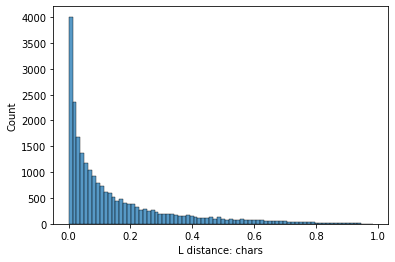

In [189]:
graph_data('L distance: chars',
           data=source_code_data)

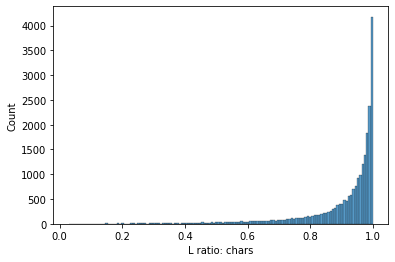

In [190]:
graph_data('L ratio: chars',
           data=source_code_data)

In [191]:
for col_name in ['L distance: chars', 'L ratio: chars']:
    print('****' + col_name + '****')
    print(f'25-й персентиль = {source_code_data[col_name].quantile(q=0.25)}')
    print(f'Медиана = {source_code_data[col_name].quantile(q=0.5)}')
    print(f'75-й персентиль = {source_code_data[col_name].quantile(q=0.75)}')

****L distance: chars****
25-й персентиль = 0.022263000307718078
Медиана = 0.0774818401937046
75-й персентиль = 0.20545313053601255
****L ratio: chars****
25-й персентиль = 0.8824274448580922
Медиана = 0.9576719576719577
75-й персентиль = 0.9877841214897608


# Отношение Левенштейна на уровне строк кода (аналог обычного diff)

Подсчитаем отношение Левенштейна для сниппетов, рассматриваемых как списки строк.

In [192]:
line_split_pattern = '\\n+'
source_code_data['L ratio: lines'] = source_code_data[['before_merge', 'after_merge']].apply(lambda x: seqratio(re.split(line_split_pattern, x['before_merge']),
                                                                                                                re.split(line_split_pattern, x['after_merge'])), 
                                                                                             axis=1)

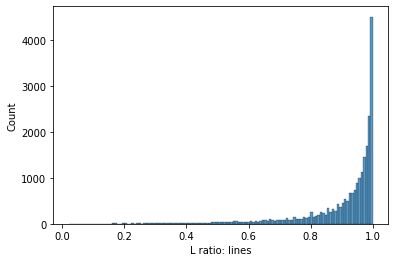

In [193]:
graph_data('L ratio: lines',
           data=source_code_data)

In [194]:
for col_name in ['L ratio: lines']:
    print('****' + col_name + '****')
    print(f'25-й персентиль = {source_code_data[col_name].quantile(q=0.25)}')
    print(f'Медиана = {source_code_data[col_name].quantile(q=0.5)}')
    print(f'75-й персентиль = {source_code_data[col_name].quantile(q=0.75)}')

****L ratio: lines****
25-й персентиль = 0.8763550457572198
Медиана = 0.9565217391304348
75-й персентиль = 0.9882202982202983


# Отношение Левенштейна на уровне токенов

Подсчитаем расстояние для сниппетов, рассматриваемых как списки токенов.

In [195]:
from tokenize import tokenize
from io import BytesIO


def tokenize_snippet(snippet):
    try:
        result = []
        for tok_type, tok_string, _, _, _  in tokenize(BytesIO(snippet.encode('utf-8')).readline):
            result.extend([str(tok_type), tok_string])
        return result
    except (TokenError, IndentationError) as te:
        token_split_pattern = '\\s+'
        return re.split(token_split_pattern, snippet)



source_code_data['L ratio: tokens'] = source_code_data[['before_merge', 'after_merge']].apply(lambda x: seqratio(tokenize_snippet(x['before_merge']),
                                                                                                                 tokenize_snippet(x['after_merge'])), 
                                                                                              axis=1)
# простая токенизация 
#token_split_pattern = '\\s+'
#source_code_data['L ratio: tokens'] = source_code_data[['before_merge', 'after_merge']].apply(lambda x: seqratio(re.split(token_split_pattern, x['before_merge']),
#                                                                                                                 re.split(token_split_pattern, x['after_merge'])), 
#                                                                                              axis=1)

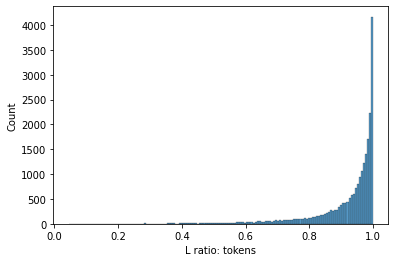

In [196]:
graph_data('L ratio: tokens',
           data=source_code_data)

In [197]:
for col_name in ['L ratio: tokens']:
    print('****' + col_name + '****')
    print(f'25-й персентиль = {source_code_data[col_name].quantile(q=0.25)}')
    print(f'Медиана = {source_code_data[col_name].quantile(q=0.5)}')
    print(f'75-й персентиль = {source_code_data[col_name].quantile(q=0.75)}')

****L ratio: tokens****
25-й персентиль = 0.8967335733973504
Медиана = 0.9616579282765146
75-й персентиль = 0.9888170967248878


Таким образом, видим примерно одинаковые результаты для представлений на уровне символов, токенов и строк. Сниппеты кода до и после исправления очень похожи

# Сравнение AST деревьев у багфиксов

In [198]:
sys.path.append('/home/kks/zephyr_local/gumtree/python_parser')
sys.path.append('/home/kks/zephyr_local/gumtree/bin')


for i in source_code_data.index:
    path_to_sinppet_file_before_merge = path_to_data + source_code_data.at[i, 'path_to_snippet_before_merge']
    path_to_sinppet_file_after_merge = path_to_data + source_code_data.at[i, 'path_to_snippet_after_merge']
    !/home/kks/zephyr_local/gumtree/bin/./gumtree diff $path_to_sinppet_file_before_merge $path_to_sinppet_file_after_merge
    break 

Unknown sub-command 'diff'.
Available Options:
-C <2>	Set system property (-c property value). 
-v	Verbose mode
--help	Display help (this screen).

Available Commands:
* webdiff: Web diff client
* cluster: Extract action clusters
* dotdiff: A dot diff client
* htmldiff: Dump diff as HTML in stdout
* list: List matchers, generators, clients and properties
* parse: Parse file and dump result.
* swingdiff: A swing diff client
* textdiff: Dump actions in a textual format.
* axmldiff: Dump annotated xml tree


# Сравнение обучающего, валидационного и тестового датасетов

In [199]:
source_code_data_train = pd.read_pickle(path_to_data + 'filtered_traceback_bugfixes_train.pickle')
source_code_data_valid = pd.read_pickle(path_to_data + 'filtered_traceback_bugfixes_valid.pickle')
source_code_data_test = pd.read_pickle(path_to_data + 'bugfixes_test.pickle')

Подсчитаем отдельно количество сниппетов каждого типа для всех датасетов.

In [200]:
source_code_data_test.rename({'bug function_name':'function_name'},
                             axis='columns',
                             inplace=True)
datasets = {'train':source_code_data_train, 'valid':source_code_data_valid, 'test':source_code_data_test}

for dataset_name in datasets:  
    datasets[dataset_name]['actual_function_name'] = datasets[dataset_name]['function_name'].apply(lambda x: x.split('.')[-1])
    datasets[dataset_name]['class_name'] = datasets[dataset_name]['function_name'].apply(lambda x: x.split('.')[0] if len(x.split('.')) == 2 else np.nan)    

# Распределение сниппетов по функциям и методам

Количество методов

In [201]:
for dataset_name in datasets:
    print(dataset_name, 'Число методов', datasets[dataset_name]['class_name'].notna().sum(), 'Доля методов', datasets[dataset_name]['class_name'].notna().sum() / datasets[dataset_name].shape[0])

train Число методов 9504 Доля методов 0.6731831704207395
valid Число методов 5891 Доля методов 0.622924817595432
test Число методов 102 Доля методов 0.6335403726708074


Количество функций

In [202]:
for dataset_name in datasets:
    print(dataset_name, 'Число функций', datasets[dataset_name]['class_name'].isna().sum(), 'Доля функций', datasets[dataset_name]['class_name'].isna().sum() / datasets[dataset_name].shape[0])

train Число функций 4614 Доля функций 0.3268168295792605
valid Число функций 3566 Доля функций 0.37707518240456805
test Число функций 59 Доля функций 0.36645962732919257


Количество private-методов:

In [203]:
for dataset_name in datasets:
    methods_data = datasets[dataset_name].loc[datasets[dataset_name]['class_name'].notna()]
    print(dataset_name, 
          'Число private методов', 
          methods_data['actual_function_name'].apply(lambda x: x.startswith('__') and (not x.endswith('__'))).sum(),
          'Доля private методов', 
          methods_data['actual_function_name'].apply(lambda x: x.startswith('__') and (not x.endswith('__'))).sum() / methods_data.shape[0])

train Число private методов 31 Доля private методов 0.0032617845117845117
valid Число private методов 55 Доля private методов 0.009336275674758105
test Число private методов 1 Доля private методов 0.00980392156862745


Количество protected-методов:

In [204]:
for dataset_name in datasets:
    methods_data = datasets[dataset_name].loc[datasets[dataset_name]['class_name'].notna()]
    print(dataset_name, 
          'Число protected методов', 
          methods_data['actual_function_name'].apply(lambda x: (len(x) > 1) and (x[0] == '_') and (x[1] != '_')).sum(),
          'Доля protected методов', 
          methods_data['actual_function_name'].apply(lambda x: (len(x) > 1) and (x[0] == '_') and (x[1] != '_')).sum() / methods_data.shape[0])

train Число protected методов 1960 Доля protected методов 0.20622895622895623
valid Число protected методов 1002 Доля protected методов 0.1700899677474113
test Число protected методов 17 Доля protected методов 0.16666666666666666


Число методов с именем из одного символа.

In [205]:
for dataset_name in datasets:
    methods_data = datasets[dataset_name].loc[datasets[dataset_name]['class_name'].notna()]
    print(dataset_name, 
          'Число методов с именем из одного символа', 
          methods_data['actual_function_name'].apply(lambda x: len(x) == 1).sum(),
          'Доля методов с именем из одного символа', 
          methods_data['actual_function_name'].apply(lambda x: len(x) == 1).sum() / methods_data.shape[0])

train Число методов с именем из одного символа 13 Доля методов с именем из одного символа 0.001367845117845118
valid Число методов с именем из одного символа 2 Доля методов с именем из одного символа 0.00033950093362756747
test Число методов с именем из одного символа 0 Доля методов с именем из одного символа 0.0


Число специальных методов `__funcname__`:

In [206]:
for dataset_name in datasets:
    methods_data = datasets[dataset_name].loc[datasets[dataset_name]['class_name'].notna()]
    print(dataset_name, 
          'Число специальных методов __funcname__:', 
          methods_data['actual_function_name'].apply(lambda x: x.startswith('__') and x.endswith('__')).sum(),
          'Доля специальных методов __funcname__', 
          methods_data['actual_function_name'].apply(lambda x: x.startswith('__') and x.endswith('__')).sum() / methods_data.shape[0])

train Число специальных методов __funcname__: 1581 Доля специальных методов __funcname__ 0.1663510101010101
valid Число специальных методов __funcname__: 751 Доля специальных методов __funcname__ 0.12748260057715158
test Число специальных методов __funcname__: 7 Доля специальных методов __funcname__ 0.06862745098039216


Число конструкторов:

In [207]:
for dataset_name in datasets:
    methods_data = datasets[dataset_name].loc[datasets[dataset_name]['class_name'].notna()]
    print(dataset_name, 
          'Число конструкторов:', 
          methods_data['actual_function_name'].apply(lambda x: x == '__init__').sum(),
          'Доля конструкторов', 
          methods_data['actual_function_name'].apply(lambda x: x == '__init__').sum() / methods_data.shape[0])

train Число конструкторов: 1086 Доля конструкторов 0.11426767676767677
valid Число конструкторов: 607 Доля конструкторов 0.10303853335596673
test Число конструкторов: 6 Доля конструкторов 0.058823529411764705


Какие бывают еще специальные функции в датасете с учетом частоты:

In [208]:
for dataset_name in datasets:
    methods_data = datasets[dataset_name].loc[datasets[dataset_name]['class_name'].notna()]
    special_methods_data = methods_data.loc[methods_data['actual_function_name'].apply(lambda x:  x.startswith('__') and 
                                                                                       x.endswith('__') and 
                                                                                       x != '__init__'), 
                                            'actual_function_name']
    df = special_methods_data.value_counts()
    print(dataset_name)
    for func_name, func_count in zip(df.index, df):
        print(func_name, 'количество', func_count, 'доля', func_count / methods_data.shape[0])
    print('***************************************************')

train
__call__ количество 129 доля 0.013573232323232324
__getitem__ количество 52 доля 0.005471380471380472
__new__ количество 40 доля 0.004208754208754209
__str__ количество 31 доля 0.0032617845117845117
__repr__ количество 28 доля 0.002946127946127946
__setitem__ количество 18 доля 0.001893939393939394
__getattr__ количество 17 доля 0.0017887205387205388
__enter__ количество 12 доля 0.0012626262626262627
__eq__ количество 12 доля 0.0012626262626262627
__add__ количество 9 доля 0.000946969696969697
__iter__ количество 9 доля 0.000946969696969697
__setstate__ количество 8 доля 0.0008417508417508417
__getstate__ количество 7 доля 0.0007365319865319865
__exit__ количество 7 доля 0.0007365319865319865
__lt__ количество 6 доля 0.0006313131313131314
__getattribute__ количество 6 доля 0.0006313131313131314
__sub__ количество 5 доля 0.0005260942760942761
__mul__ количество 5 доля 0.0005260942760942761
__del__ количество 5 доля 0.0005260942760942761
__pow__ количество 4 доля 0.0004208754208754

Наиболее часто встречающиеся специальные функции, неконструкторы - это `__getitem__` и `__call__`.

Количество непубличных функций:

In [209]:
for dataset_name in datasets:
    functions_data = datasets[dataset_name].loc[datasets[dataset_name]['class_name'].isna()]
    print(dataset_name, 
          'Число непубличных функций:', 
          functions_data['actual_function_name'].apply(lambda x: (len(x) > 1) and (x.startswith('_'))).sum(),
          'Доля непубличных функций', 
          functions_data['actual_function_name'].apply(lambda x: (len(x) > 1) and (x.startswith('_'))).sum() / functions_data.shape[0])

train Число непубличных функций: 851 Доля непубличных функций 0.1844386649328132
valid Число непубличных функций: 630 Доля непубличных функций 0.17666853617498599
test Число непубличных функций: 6 Доля непубличных функций 0.1016949152542373


Количество специальных функций:

In [210]:
for dataset_name in datasets:
    functions_data = datasets[dataset_name].loc[datasets[dataset_name]['class_name'].isna()]
    print(dataset_name, 
          'Число специальных функций:', 
          functions_data['actual_function_name'].apply(lambda x: x.startswith('__') and x.endswith('__')).sum(),
          'Доля специальных функций', 
          functions_data['actual_function_name'].apply(lambda x: x.startswith('__') and x.endswith('__')).sum() / functions_data.shape[0])

train Число специальных функций: 73 Доля специальных функций 0.015821413090593844
valid Число специальных функций: 97 Доля специальных функций 0.027201346045989904
test Число специальных функций: 0 Доля специальных функций 0.0


Количество функций `__init__`:

In [211]:
for dataset_name in datasets:
    functions_data = datasets[dataset_name].loc[datasets[dataset_name]['class_name'].isna()]
    print(dataset_name, 
          'Число функций __init__:', 
          functions_data['actual_function_name'].apply(lambda x: x == '__init__').sum(),
          'Доля функций __init__', 
          functions_data['actual_function_name'].apply(lambda x: x == '__init__').sum() / functions_data.shape[0])

train Число функций __init__: 35 Доля функций __init__ 0.007585609016038145
valid Число функций __init__: 25 Доля функций __init__ 0.007010656197420078
test Число функций __init__: 0 Доля функций __init__ 0.0


Таким образом, функции `__init__` и конструкторы очень часто встречаются среди специальных функций.

Количество асинхронных функций и методов:

In [212]:
for dataset_name in datasets:
    print(dataset_name, 
          'Число асинхронных функций и методов:', 
          datasets[dataset_name]['before_merge'].apply(lambda x: 'async def' in x.split('\n')[0] if len(x.split('\n')) == 1 else
                                                       ('async def' in x.split('\n')[0]) or ('async def' in x.split('\n')[1])).sum(),
          'Доля асинхронных функций и методов:', 
          datasets[dataset_name]['before_merge'].apply(lambda x: 'async def' in x.split('\n')[0] if len(x.split('\n')) == 1 else
                                                       ('async def' in x.split('\n')[0]) or ('async def' in x.split('\n')[1])).sum() / datasets[dataset_name].shape[0])

train Число асинхронных функций и методов: 307 Доля асинхронных функций и методов: 0.021745289701090804
valid Число асинхронных функций и методов: 467 Доля асинхронных функций и методов: 0.04938141059532621
test Число асинхронных функций и методов: 4 Доля асинхронных функций и методов: 0.024844720496894408


Таким образом, с учетом разброса долей (см число наблюдений) разницей в долях между обучающим, валидационным и тестовым датасетами можно пренебречь.

# Сравнение распределений по всем ранее вычисленным сырым метрикам

Сравнение распределений будем проводить по следующим метрикам:

- длина кода
- длина кода без докстрингов
- число аргументов функций и методов
- число простых присвоений
- число простых присвоений атрибутам
- число вызовов функций
- длина и количество докстрингов.

In [213]:
import ast
from tokenize import TokenError
from tokenize import TokenError
from pyminifier.minification import remove_comments_and_docstrings

def extractDocstring(snippet):
    try:
        tree = ast.parse(snippet)
    
        docstrings = []
        for node in ast.walk(tree):
            if isinstance(node, tuple({ast.FunctionDef: 'Function/Method',
                                       ast.ClassDef: 'Class'})):
                docstring = ast.get_docstring(node)
                if docstring:
                    docstrings.append(docstring)
        return docstrings
    except (TokenError, IndentationError) as te:
        return []
    

def removeCommentsAndDocstrings(snippet):
    try:
        return remove_comments_and_docstrings(snippet)
    except (TokenError, IndentationError) as te:
        return snippet

In [214]:
datasets['test']['before_merge_without_docstrings'] = datasets['test']['before_merge'].apply(refineSnippet).apply(removeCommentsAndDocstrings)
datasets['test']['before_merge_docstrings'] = datasets['test']['before_merge'].apply(refineSnippet).apply(extractDocstring)

In [215]:
for dataset_name in datasets:
    datasets[dataset_name]['before_merge_refined'] = datasets[dataset_name]['before_merge'].apply(refineSnippet)
    datasets[dataset_name] = datasets[dataset_name].loc[datasets[dataset_name]['before_merge_refined'].notna()]
    datasets[dataset_name]['before_merge_without_docstrings_refined'] = datasets[dataset_name]['before_merge_without_docstrings'].apply(refineSnippet)
    datasets[dataset_name] = datasets[dataset_name].loc[datasets[dataset_name]['before_merge_without_docstrings_refined'].notna()]
    
    datasets[dataset_name].loc[:, 'number_of_arguments_before'] = datasets[dataset_name]['before_merge_refined'].apply(getArgumentsCount)
    datasets[dataset_name].loc[:, 'code_length_before'] = datasets[dataset_name]['before_merge_refined'].apply(len)
    datasets[dataset_name].loc[:, 'code_length_wd_before'] = datasets[dataset_name]['before_merge_without_docstrings_refined'].apply(len)
    datasets[dataset_name].loc[:, 'number_of_distinct_simple_assignments_before'] = datasets[dataset_name]['before_merge_refined'].apply(getSimpleAssignmentsCount)
    datasets[dataset_name].loc[:, 'number_of_distinct_attribute_assignments_before'] = datasets[dataset_name]['before_merge_refined'].apply(getSimpleAttributeAssignmentsCount)
    datasets[dataset_name].loc[:, 'number_of_function_calls_before'] = datasets[dataset_name]['before_merge_refined'].apply(getFunctionCallCount)
    datasets[dataset_name].loc[:, 'total_length_of_docstrings_before'] = datasets[dataset_name]['before_merge_docstrings'].apply(lambda x: sum([len(docstring) for docstring in x]))
    datasets[dataset_name].loc[:, 'total_count_of_docstrings_before'] = datasets[dataset_name]['before_merge_docstrings'].apply(len)

<ipython-input-215-2157c1334fb0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasets[dataset_name]['before_merge_without_docstrings_refined'] = datasets[dataset_name]['before_merge_without_docstrings'].apply(refineSnippet)


In [216]:
all_data = pd.concat((datasets[dataset_name] for dataset_name in datasets), axis=0)
all_data['index'] = np.nan

for dataset_name in datasets:
    all_data.loc[datasets[dataset_name].index, 'index'] = dataset_name

In [217]:
metrics_names = ['code_length', 'code_length_wd', 'number_of_arguments', 'number_of_distinct_simple_assignments', 'number_of_distinct_attribute_assignments',
                 'number_of_function_calls', 'total_length_of_docstrings', 'total_count_of_docstrings']

In [218]:
from scipy.stats import kruskal, ks_2samp, mannwhitneyu
from statsmodels.stats.multitest import multipletests

## Функция оценки статистической значимости различий распределений

In [219]:
def significantFeatures(datasets, 
                        features, 
                        test_function,
                        test_key_params={},
                        remove_outliers=False,
                        confidence_level=0.05):
    p_values = []
    for feature_name in features:
        p_values.append(test_function(*[datasets[dataset_name][feature_name] for dataset_name in datasets],
                                          **test_key_params)[1])
    is_feature_predictive, features_p_values_corrected, _, _ = multipletests(p_values, 
                                                                             alpha=confidence_level,
                                                                             method='fdr_bh',
                                                                             returnsorted=False)
    return [feature_name for i, feature_name in enumerate(features) if is_feature_predictive[i]], features_p_values_corrected

Сравним распределения по метрикам:

In [220]:
kw_predictive_metrics_names, kw_p_values = significantFeatures(datasets,
                                                               [metric_name + '_before' for metric_name in metrics_names],
                                                               test_function=kruskal,
                                                               confidence_level=0.05)

In [221]:
kw_predictive_metrics_names

['code_length_before',
 'code_length_wd_before',
 'number_of_arguments_before',
 'number_of_distinct_simple_assignments_before',
 'number_of_distinct_attribute_assignments_before',
 'number_of_function_calls_before',
 'total_length_of_docstrings_before',
 'total_count_of_docstrings_before']

Получили что по всем метрикам есть разница в распределениях. Построим графики:

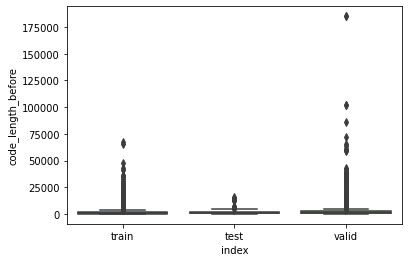

In [222]:
sns.boxplot(x='index', y='code_length_before',
            data=all_data);

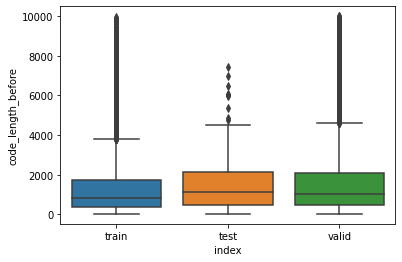

In [223]:
sns.boxplot(x='index', y='code_length_before',
            data=all_data.loc[all_data['code_length_before'] < 10000]);

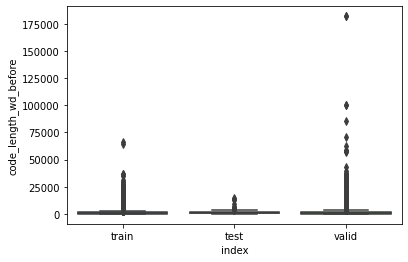

In [224]:
sns.boxplot(x='index', y='code_length_wd_before',
            data=all_data);

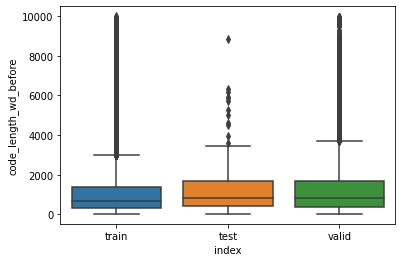

In [225]:
sns.boxplot(x='index', y='code_length_wd_before',
            data=all_data.loc[all_data['code_length_wd_before'] < 10000]);

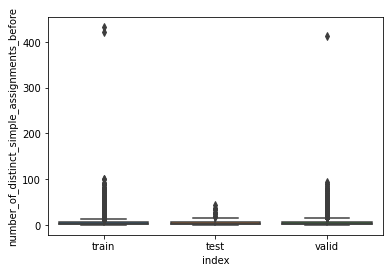

In [226]:
sns.boxplot(x='index', y='number_of_distinct_simple_assignments_before',
            data=all_data);

Удалим выбросы:

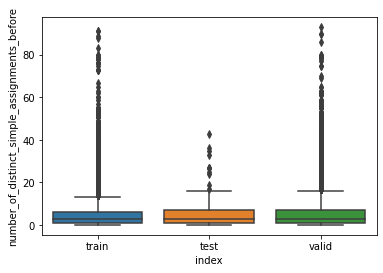

In [227]:
sns.boxplot(x='index', y='number_of_distinct_simple_assignments_before',
            data=all_data.loc[all_data['number_of_distinct_simple_assignments_before'] < 100]);

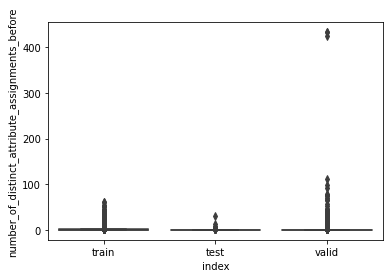

In [228]:
sns.boxplot(x='index', y='number_of_distinct_attribute_assignments_before',
            data=all_data);

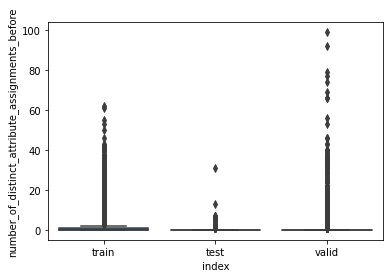

In [229]:
sns.boxplot(x='index', y='number_of_distinct_attribute_assignments_before',
            data=all_data.loc[all_data['number_of_distinct_attribute_assignments_before'] < 100]);

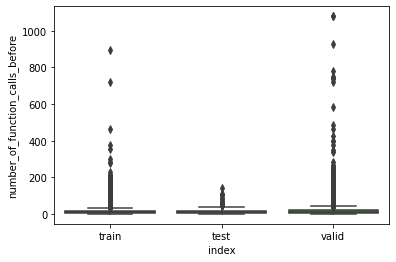

In [230]:
sns.boxplot(x='index', y='number_of_function_calls_before',
            data=all_data);

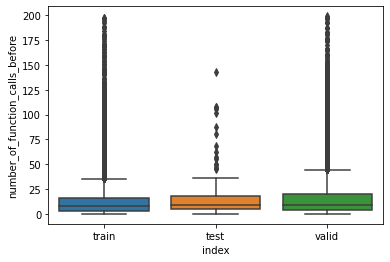

In [231]:
sns.boxplot(x='index', y='number_of_function_calls_before',
            data=all_data.loc[all_data['number_of_function_calls_before'] < 200]);

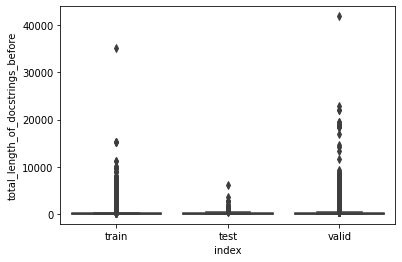

In [232]:
sns.boxplot(x='index', y='total_length_of_docstrings_before',
            data=all_data);

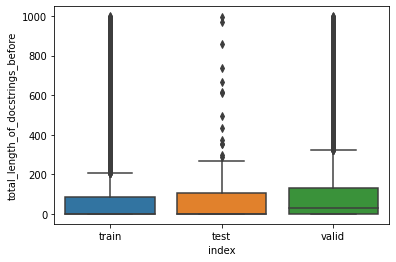

In [233]:
sns.boxplot(x='index', y='total_length_of_docstrings_before',
            data=all_data.loc[all_data['total_length_of_docstrings_before'] < 1000]);

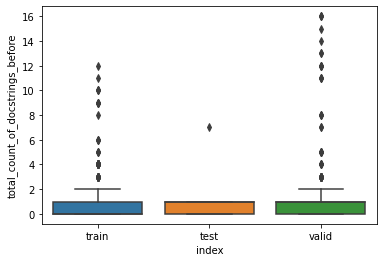

In [234]:
sns.boxplot(x='index', y='total_count_of_docstrings_before',
            data=all_data);

Тестовый датасет отличается от обучающего и валидационного бОльшей длиной и количеством докстрингов. По остальным метрикам разница незначительная.

# Краткое сравнение датасетов по кругу репозиториев

In [235]:
for dataset_name in datasets:
    datasets[dataset_name]['repo_name'] = datasets[dataset_name]['url'].apply(lambda x: '/'.join(x.split('/')[3:5]))

Обучающий и тестовый датасет не пересекаются по репозиториям:

In [236]:
set(datasets['train']['repo_name']) & set(datasets['test']['repo_name'])

set()

Все репозитории тестового датасета содержатся среди репозиториев валидационного:

In [237]:
set(datasets['test']['repo_name']).issubset(set(datasets['valid']['repo_name']))

True

Распределение сниппетов по репозиториям в обучающем датасете:

In [238]:
df = datasets['train']['repo_name'].value_counts()

for index, count in zip(df.index, df):
    print(index, count) 

pandas-dev/pandas 708
mars-project/mars 635
numba/numba 604
python/mypy 342
conda/conda 306
ray-project/ray 261
pytroll/satpy 227
iterative/dvc 221
modin-project/modin 220
qutebrowser/qutebrowser 200
google/jax 184
MobSF/Mobile-Security-Framework-MobSF 135
DataBiosphere/toil 126
galaxyproject/galaxy 123
janeczku/calibre-web 116
riptideio/pymodbus 113
cornellius-gp/gpytorch 108
matrix-org/synapse 107
napari/napari 104
numpy/numpy 104
pantsbuild/pex 102
leo-editor/leo-editor 96
sqlalchemy/sqlalchemy 92
nucypher/nucypher 91
statsmodels/statsmodels 91
conan-io/conan 89
Trusted-AI/adversarial-robustness-toolbox 84
WeblateOrg/weblate 83
cloud-custodian/cloud-custodian 82
hbldh/bleak 82
edgedb/edgedb 79
google/pytype 77
celery/celery 72
hyperspy/hyperspy 71
tox-dev/tox 70
yt-project/yt 70
pantsbuild/pants 69
ipython/ipython 68
mopidy/mopidy 66
beetbox/beets 66
spack/spack 66
RaRe-Technologies/gensim 65
mne-tools/mne-python 65
snakemake/snakemake 64
hylang/hy 64
apache/airflow 63
pymc-devs/pym

В валидационном:

In [239]:
df = datasets['valid']['repo_name'].value_counts()

for index, count in zip(df.index, df):
    print(index, count) 

saltstack/salt 1801
ansible/ansible 1403
Tribler/tribler 713
spyder-ide/spyder 546
Cog-Creators/Red-DiscordBot 440
pymedusa/Medusa 352
log2timeline/plaso 300
scikit-learn/scikit-learn 244
freqtrade/freqtrade 230
sphinx-doc/sphinx 216
scipy/scipy 201
PyTorchLightning/pytorch-lightning 159
Azure/azure-cli 159
pydata/xarray 146
mitmproxy/mitmproxy 140
CellProfiler/CellProfiler 135
getnikola/nikola 129
RasaHQ/rasa 129
xonsh/xonsh 119
custom-components/alexa_media_player 98
Flexget/Flexget 97
nicolargo/glances 93
pypa/pipenv 91
Qiskit/qiskit-terra 90
pypa/pip 81
certtools/intelmq 80
spesmilo/electrum 77
ParallelSSH/parallel-ssh 68
biolab/orange3 64
databricks/koalas 59
holoviz/holoviews 58
pydicom/pydicom 57
evennia/evennia 55
awslabs/gluon-ts 53
facebookresearch/hydra 50
psychopy/psychopy 48
zulip/zulip 45
SciTools/iris 36
certbot/certbot 35
quodlibet/quodlibet 35
fossasia/open-event-server 31
aiogram/aiogram 28
ibis-project/ibis 28
postlund/pyatv 27
OpenNMT/OpenNMT-tf 26
DMOJ/judge-server

В тестовом:

In [240]:
df = datasets['test']['repo_name'].value_counts()

for index, count in zip(df.index, df):
    print(index, count) 

certtools/intelmq 16
ansible/ansible 14
scikit-image/scikit-image 10
Rapptz/discord.py 9
saltstack/salt 7
espnet/espnet 5
xonsh/xonsh 5
pypa/pipenv 4
Tribler/tribler 4
mitmproxy/mitmproxy 3
PyTorchLightning/pytorch-lightning 3
SciTools/iris 3
frappe/erpnext 2
Flexget/Flexget 2
pymedusa/Medusa 2
Cog-Creators/Red-DiscordBot 2
spyder-ide/spyder 2
jpadilla/pyjwt 2
biolab/orange3 2
sphinx-doc/sphinx 2
jazzband/django-debug-toolbar 2
Azure/azure-cli 2
scikit-learn/scikit-learn 2
evennia/evennia 2
scipy/scipy 2
freqtrade/freqtrade 2
python-poetry/poetry 2
ansible-community/molecule 1
nicolargo/glances 1
holoviz/holoviews 1
fossasia/open-event-server 1
awslabs/gluon-ts 1
telepresenceio/telepresence 1
spesmilo/electrum 1
astropy/astroquery 1
OpenShot/openshot-qt 1
Qiskit/qiskit-terra 1
postlund/pyatv 1
PrefectHQ/prefect 1
Ericsson/codechecker 1
getnikola/nikola 1
zulip/zulip 1
aiogram/aiogram 1
OpenNMT/OpenNMT-tf 1
log2timeline/plaso 1
buildbot/buildbot 1
pypa/pip 1
GenericMappingTools/pygmt 1


# Распределение по типам ошибок

Распределение типов ошибок на обучающем датасете

In [241]:
df = datasets['train']['traceback_type'].value_counts()

for index, count in zip(df.index, df):
    print(index, count)

AttributeError 2341
TypeError 2217
ValueError 1649
KeyError 1077
IndexError 887
AssertionError 643
RuntimeError 558
Exception 244
ImportError 240
FileNotFoundError 211
OSError 184
UnicodeDecodeError 160
NotImplementedError 125
ModuleNotFoundError 108
OperationalError 104
UnboundLocalError 92
subprocess.CalledProcessError 89
IOError 88
UnicodeEncodeError 86
NameError 79
RecursionError 76
ZeroDivisionError 65
PermissionError 59
dvc.exceptions.RemoteCacheRequiredError 54
sqlite3.OperationalError 47
botocore.exceptions.ClientError 47
pydantic.error_wrappers.ValidationError 44
bleak.exc.BleakError 43
ConnectionResetError 40
SystemError 38
SyntaxError 37
BrokenPipeError 36
sphinx.errors.SphinxWarning 30
json.decoder.JSONDecodeError 30
LookupError 29
OverflowError 28
struct.error 26
FileExistsError 26
hy.errors.HyCompileError 26
pants.engine.internals.scheduler.ExecutionError 25
telegram.error.BadRequest 25
ssl.SSLCertVerificationError 24
psutil._error.NoSuchProcess 23
MySQLdb._exceptions.Ope

youtube_dl.socks.Socks5Error 1
rasterio._err.CPLE_AWSAccessDeniedError 1
FirstError 1
RemoteError 1
angr.errors.SimEngineError 1
tornado.curl_httpclient.CurlError 1
InvalidArgumentError 1
dynaconf.validator.ValidationError 1
galaxy.exceptions.ItemAccessibilityException 1
NonMatchingChecksumError 1
exceptions.UnicodeError 1
netaddr.core.AddrFormatError 1
OperationFailureException 1
exceptions.UnboundLocalError 1
pymongo.errors.OperationFailure 1
botocore.errorfactory.ValidationException 1
PolynomialError 1
urllib3.exceptions.ProtocolError 1
configexc.ConfigFileError 1
flask_api.exceptions.ParseError 1
OpenSSL.SSL.Error 1
tvm._ffi.base.TVMError 1
ConfigurationError 1
toil.jobStores.abstractJobStore.JobStoreExistsException 1
_pickle.PicklingError 1
exceptions.TypeError 1
GitSavvy.core.git_command.GitSavvyError 1
httptools.parser.errors.HttpParserInvalidMethodError 1
requests.packages.urllib3.exceptions.ReadTimeoutError 1
nTypeError 1
angr.errors.AngrSyscallError 1
pyodbc.Error 1
__main__.

наиболее часто встречающиеся ошибки:
    
- AttributeError
- TypeError
- ValueError
- KeyError
- RuntimeError
- IndexError
- AssertionError

Распределение типов ошибок на валидационном датасете

In [242]:
df = datasets['valid']['traceback_type'].value_counts()

for index, count in zip(df.index, df):
    print(index, count)

AttributeError 1592
TypeError 1562
KeyError 884
ValueError 779
RuntimeError 750
IndexError 387
AssertionError 266
UnicodeEncodeError 217
UnicodeDecodeError 214
Exception 158
OSError 148
NameError 131
UnboundLocalError 115
IOError 83
FileNotFoundError 81
ImportError 76
nTypeError 73
CommandExecutionError 64
MemoryError 45
nAttributeError 45
json.decoder.JSONDecodeError 40
ZeroDivisionError 37
OverflowError 36
exceptions.AttributeError 36
TimeoutError 35
isError 31
pssh.exceptions.AuthenticationException 31
SyntaxError 30
WindowsError 30
requests.exceptions.ConnectionError 28
ConnectionError 27
mxnet.base.MXNetError 27
PermissionError 26
tensorflow.python.framework.errors_impl.InvalidArgumentError 26
ModuleNotFoundError 25
tribler_gui.event_request_manager.CoreConnectTimeoutError 25
EOFError 23
tower_cli.exceptions.AuthError 22
ansible.module_utils.connection.ConnectionError 20
optparse.OptionConflictError 19
ProgrammingError 19
SaltClientError 19
PackError 18
LookupError 18
ParserError 

наиболее часто встречающиеся ошибки те же самые:
    
- AttributeError
- TypeError
- ValueError
- KeyError
- RuntimeError
- IndexError
- AssertionError

Теперь на тесте:

In [243]:
df = datasets['test']['traceback_type'].value_counts()

for index, count in zip(df.index, df):
    print(index, count)

AttributeError 31
TypeError 28
KeyError 15
ValueError 12
IndexError 11
RuntimeError 5
UnboundLocalError 4
FileNotFoundError 4
PermissionError 3
UnicodeEncodeError 3
intelmq.lib.exceptions.InvalidValue 3
UnicodeDecodeError 2
NameError 2
UnicodeError 2
AssertionError 2
IOError 2
intelmq.lib.exceptions.PipelineError 2
Exception 2
OSError 2
freqtrade.OperationalException 1
frappe.exceptions.DoesNotExistError 1
gaierror 1
nAttributeError 1
pygmt.exceptions.GMTCLibError 1
pipenv.patched.piptools.exceptions.NoCandidateFound 1
PluginParseError 1
BrokenPipeError 1
psycopg2.DataError 1
alexapy.errors.AlexapyLoginError 1
tomlkit.exceptions.NonExistentKey 1
_csv.Error 1
tensorflow.python.framework.errors_impl.InvalidArgumentError 1
ZeroDivisionError 1
lxml.etree.ParserError 1
socket.gaierror 1
nValueError 1
OverflowError 1
sqlite3.OperationalError 1


Практически все самые популярные в предыдущих двух датасетах типы ошибок попали в тестовый датасет:

- AttributeError 34
- TypeError 29
- KeyError 15
- ValueError 13
- IndexError 11
- RuntimeError 5